# Hybrid Probabilistic Model for Football Match Prediction

This notebook implements an end-to-end data science pipeline that combines:
1. **Hidden Markov Model (HMM)** to infer latent "team momentum" variables
2. **Static Bayesian Networks (BN)** using the momentum as features
3. **Comparative analysis** of three BN structures: Naive Bayes, Expert DAG, and Learned DAG
4. **Exact vs. Approximate Inference** comparison
5. **Model evaluation** and report generation

---


## 1. Setup & Dependencies

This section installs all required packages and imports necessary libraries.


In [1]:
# Install all required dependencies
# Note: Works in both Jupyter and Google Colab
# Install Python packages (works in both Jupyter and Colab)
%pip install pandas numpy matplotlib seaborn scikit-learn pgmpy hmmlearn networkx graphviz tabulate kaggle -q

# Install system dependencies for graphviz (only needed in Colab)
# Check if running in Google Colab
try:
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Running in Google Colab - install graphviz system binaries
    import os
    os.system('apt-get update -qq && apt-get install -y -qq graphviz > /dev/null 2>&1')
else:
    # Not in Colab - jupyterlab needed for local Jupyter
    # Note: On local systems, install graphviz via: brew install graphviz (macOS) or apt-get install graphviz (Linux)
    %pip install jupyterlab -q


Note: you may need to restart the kernel to use updated packages.


sh: apt-get: command not found


In [2]:
# Standard library imports
import os
import warnings
from typing import Tuple, List, Dict, Optional, Any
from collections import defaultdict
import json

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.calibration import calibration_curve

# Probabilistic Models
# Try to import DiscreteBayesianNetwork (newer pgmpy) or fallback to BayesianNetwork (older pgmpy)
try:
    from pgmpy.models import DiscreteBayesianNetwork
    BAYESIAN_NETWORK_CLASS = DiscreteBayesianNetwork
except ImportError:
    from pgmpy.models import BayesianNetwork
    BAYESIAN_NETWORK_CLASS = BayesianNetwork
    print("Note: Using deprecated BayesianNetwork. Consider upgrading pgmpy for DiscreteBayesianNetwork.")

from pgmpy.models import DynamicBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import HillClimbSearch, PC, MaximumLikelihoodEstimator
from hmmlearn import hmm
# Use CategoricalHMM for categorical/discrete observations (not MultinomialHMM)
# CategoricalHMM is the correct choice for our use case (discrete match outcomes)

# Try to import GibbsSampling from different possible locations (pgmpy version compatibility)
# Note: pgmpy API has changed across versions, so we try multiple import paths
try:
    from pgmpy.inference import GibbsSampling, ApproxInference
except ImportError:
    try:
        from pgmpy.sampling import GibbsSampling
        ApproxInference = None  # ApproxInference might not be available
    except ImportError:
        try:
            from pgmpy.sampling.Gibbs import GibbsSampling
            ApproxInference = None
        except ImportError:
            try:
                # Try importing from sampling module directly
                import pgmpy.sampling
                GibbsSampling = getattr(pgmpy.sampling, 'GibbsSampling', None)
                ApproxInference = None
            except (ImportError, AttributeError):
                # If all imports fail, we'll handle it gracefully in the code
                GibbsSampling = None
                ApproxInference = None
                print("Warning: GibbsSampling not available. Approximate inference will be limited.")
                print("Note: You can still use VariableElimination for exact inference.")

# Graph visualization
import networkx as nx

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


/Users/fashad/fashad/unibo-projects/mod3-miniproject/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Helper Function Definitions

All helper functions for the entire project are defined here, organized by functional area.


### 2.1. Data Loading & Preprocessing


In [3]:
def load_football_data(filepath: str) -> pd.DataFrame:
    """
    Load the football match data from CSV file.
    
    Args:
        filepath: Path to the Matches.csv file
        
    Returns:
        DataFrame containing match data
    """
    df = pd.read_csv(filepath)
    print(f"Loaded {len(df)} matches from {filepath}")
    return df


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the football match data by handling missing values and filtering valid matches.
    
    Args:
        df: Raw match DataFrame
        
    Returns:
        Cleaned DataFrame
    """
    # Create a copy to avoid modifying original
    df_clean = df.copy()
    
    # Map column names to handle different dataset formats
    # Check for alternative column names (FTHome/FTAway/FTResult vs FTHG/FTAG/FTR)
    if 'FTHome' in df_clean.columns and 'FTAway' in df_clean.columns:
        # Copy values, preserving NaN (will be filtered out later)
        df_clean['FTHG'] = df_clean['FTHome'].copy()
        df_clean['FTAG'] = df_clean['FTAway'].copy()
    elif 'FTHG' not in df_clean.columns or 'FTAG' not in df_clean.columns:
        # If neither format exists, we can't proceed
        raise ValueError("Neither FTHome/FTAway nor FTHG/FTAG columns found in dataset")
    
    if 'FTResult' in df_clean.columns:
        # Copy values, preserving NaN (will be filtered out later)
        df_clean['FTR'] = df_clean['FTResult'].copy()
    elif 'FTR' not in df_clean.columns:
        raise ValueError("Neither FTResult nor FTR column found in dataset")
    
    # Check for NaN in critical columns before filtering
    nan_check = df_clean[['FTHG', 'FTAG', 'FTR']].isna().sum()
    if nan_check.sum() > 0:
        print(f"\nWarning: Found NaN values in score/result columns:")
        print(nan_check[nan_check > 0])
    
    # Filter out matches with missing critical information
    # First, ensure we have the required columns
    required_cols = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']
    missing_cols = [col for col in required_cols if col not in df_clean.columns]
    if missing_cols:
        raise ValueError(f"Required columns missing: {missing_cols}")
    
    # Drop rows with NaN in critical columns
    initial_count = len(df_clean)
    df_clean = df_clean.dropna(subset=required_cols)
    dropped_count = initial_count - len(df_clean)
    if dropped_count > 0:
        print(f"Dropped {dropped_count} rows with missing critical data (NaN in {required_cols})")
    
    # Remove matches with invalid scores (negative or extremely high)
    # Also filter out NaN values that might have passed through
    if 'FTHG' in df_clean.columns and 'FTAG' in df_clean.columns:
        before_filter = len(df_clean)
        df_clean = df_clean[
            (df_clean['FTHG'].notna()) & 
            (df_clean['FTAG'].notna()) &
            (df_clean['FTHG'] >= 0) & 
            (df_clean['FTAG'] >= 0) &
            (df_clean['FTHG'] <= 15) & 
            (df_clean['FTAG'] <= 15)
        ]
        filtered_count = before_filter - len(df_clean)
        if filtered_count > 0:
            print(f"Filtered out {filtered_count} rows with invalid scores")
    
    # Convert date column if present (handle both 'Date' and 'MatchDate')
    date_col = None
    if 'MatchDate' in df_clean.columns:
        date_col = 'MatchDate'
        df_clean['Date'] = pd.to_datetime(df_clean['MatchDate'], errors='coerce')
    elif 'Date' in df_clean.columns:
        date_col = 'Date'
        df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce')
    
    if date_col:
        before_date = len(df_clean)
        df_clean = df_clean.dropna(subset=['Date'])
        date_dropped = before_date - len(df_clean)
        if date_dropped > 0:
            print(f"Dropped {date_dropped} rows with missing dates")
        df_clean = df_clean.sort_values('Date')
    
    print(f"\nAfter cleaning: {len(df_clean)} matches remaining")
    
    # Final check: verify no NaN in critical columns
    critical_final = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']
    critical_final_existing = [col for col in critical_final if col in df_clean.columns]
    if critical_final_existing:
        final_nan = df_clean[critical_final_existing].isna().sum()
        if final_nan.sum() > 0:
            print(f"\n⚠ Warning: Still have NaN in critical columns after cleaning:")
            print(final_nan[final_nan > 0])
        else:
            print("✓ All critical columns are clean (no NaN values)")
    
    # Show NaN summary for non-critical columns (this is expected and fine)
    non_critical_cols = [col for col in df_clean.columns if col not in critical_final_existing + ['Date']]
    if non_critical_cols:
        non_critical_nan = df_clean[non_critical_cols].isna().sum()
        nan_cols = non_critical_nan[non_critical_nan > 0]
        if len(nan_cols) > 0:
            print(f"\nNote: {len(nan_cols)} non-critical columns have NaN values (this is fine - they're optional features)")
            print(f"Examples: {list(nan_cols.head(5).index)}")
    
    return df_clean


def compute_elo_ratings(df: pd.DataFrame, initial_elo: float = 1500.0, k_factor: float = 32.0) -> pd.DataFrame:
    """
    Compute Elo ratings for teams based on match results.
    
    Args:
        df: DataFrame with match results, sorted by date
        initial_elo: Starting Elo rating for all teams
        k_factor: K-factor for Elo calculation
        
    Returns:
        DataFrame with HomeElo and AwayElo columns added
    """
    df_elo = df.copy()
    
    # Check if Elo columns already exist - if so, use them directly
    if 'HomeElo' in df_elo.columns and 'AwayElo' in df_elo.columns:
        print("Elo ratings already present in dataset, using existing values")
        return df_elo
    
    # Initialize Elo dictionary
    elo_dict = defaultdict(lambda: initial_elo)
    
    # Lists to store Elo values for each match
    home_elos = []
    away_elos = []
    
    for idx, row in df_elo.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        
        # Get current Elo ratings
        home_elo = elo_dict[home_team]
        away_elo = elo_dict[away_team]
        
        # Home advantage (typically +100 Elo points)
        home_advantage = 100
        home_elo_adj = home_elo + home_advantage
        
        # Expected scores
        expected_home = 1 / (1 + 10 ** ((away_elo - home_elo_adj) / 400))
        expected_away = 1 - expected_home
        
        # Actual scores
        if row['FTR'] == 'H':
            actual_home = 1.0
            actual_away = 0.0
        elif row['FTR'] == 'A':
            actual_home = 0.0
            actual_away = 1.0
        else:  # Draw
            actual_home = 0.5
            actual_away = 0.5
        
        # Update Elo ratings
        elo_dict[home_team] = home_elo + k_factor * (actual_home - expected_home)
        elo_dict[away_team] = away_elo + k_factor * (actual_away - expected_away)
        
        # Store Elo values for this match (before update, to reflect pre-match state)
        home_elos.append(home_elo)
        away_elos.append(away_elo)
    
    df_elo['HomeElo'] = home_elos
    df_elo['AwayElo'] = away_elos
    
    return df_elo


### 2.2. Feature Engineering & Discretization


In [4]:
def discretize_elo(elo: pd.Series, n_bins: int = 5) -> pd.Series:
    """
    Discretize Elo ratings into bins.
    
    Args:
        elo: Series of Elo ratings
        n_bins: Number of bins for discretization
        
    Returns:
        Series of discretized Elo values
    """
    # Use quantile-based binning for more balanced distribution
    labels = [f'Elo_{i+1}' for i in range(n_bins)]
    return pd.qcut(elo, q=n_bins, labels=labels, duplicates='drop')


def discretize_momentum(momentum: pd.Series, n_states: int = 5) -> pd.Series:
    """
    Discretize momentum values into states.
    
    Args:
        momentum: Series of momentum values (HMM states)
        n_states: Number of states
        
    Returns:
        Series of discretized momentum values
    """
    # Momentum is already discrete (HMM states), just ensure proper labeling
    return momentum.astype(str).apply(lambda x: f'Momentum_{x}')


def create_match_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create additional features for matches.
    
    Args:
        df: DataFrame with match data
        
    Returns:
        DataFrame with additional features
    """
    df_feat = df.copy()
    
    # Ensure FTR column exists and is in the correct format
    if 'FTR' not in df_feat.columns:
        raise ValueError("FTR column not found. Please ensure the dataset has match results.")
    
    # Goal difference
    if 'FTHG' in df_feat.columns and 'FTAG' in df_feat.columns:
        df_feat['GoalDiff'] = df_feat['FTHG'] - df_feat['FTAG']
        
        # Total goals
        df_feat['TotalGoals'] = df_feat['FTHG'] + df_feat['FTAG']
    
    # Result encoding (for HMM observations)
    # Handle different result encodings
    if df_feat['FTR'].dtype == 'object':
        # Map string results: H=Home, D=Draw, A=Away
        result_map = {'H': 0, 'D': 1, 'A': 2, 'Home': 0, 'Draw': 1, 'Away': 2}
        df_feat['Result'] = df_feat['FTR'].map(result_map)
        # Fill any unmapped values with mode or default
        if df_feat['Result'].isna().any():
            # Try to infer from goal difference if available
            if 'GoalDiff' in df_feat.columns:
                df_feat.loc[df_feat['Result'].isna() & (df_feat['GoalDiff'] > 0), 'Result'] = 0  # Home win
                df_feat.loc[df_feat['Result'].isna() & (df_feat['GoalDiff'] < 0), 'Result'] = 2  # Away win
                df_feat.loc[df_feat['Result'].isna() & (df_feat['GoalDiff'] == 0), 'Result'] = 1  # Draw
            df_feat['Result'] = df_feat['Result'].fillna(1)  # Default to draw if still missing
    else:
        # If numeric, assume 0=H, 1=D, 2=A or similar encoding
        df_feat['Result'] = df_feat['FTR'].astype(int)
    
    return df_feat


### 2.3. HMM Modeling


In [5]:
def create_hmm_sequences(df: pd.DataFrame, team: str, window_size: int = 10) -> List[np.ndarray]:
    """
    Create observation sequences for HMM training from a team's match history.
    
    Args:
        df: DataFrame with match data
        team: Team name
        window_size: Number of recent matches to use for sequence
        
    Returns:
        List of observation sequences (each sequence is a numpy array)
    """
    sequences = []
    
    # Get all matches for this team (both home and away)
    team_matches = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)].copy()
    team_matches = team_matches.sort_values('Date' if 'Date' in team_matches.columns else team_matches.index)
    
    if len(team_matches) < window_size:
        return sequences
    
    # Create sequences using sliding window
    for i in range(len(team_matches) - window_size + 1):
        window = team_matches.iloc[i:i+window_size]
        
        # Create observation sequence: (goals_for_bin, goals_against_bin, result)
        obs_seq = []
        for _, match in window.iterrows():
            if match['HomeTeam'] == team:
                gf = int(match['FTHG'])
                ga = int(match['FTAG'])
                result = match['Result']
            else:
                gf = int(match['FTAG'])
                ga = int(match['FTHG'])
                result = 2 - match['Result']  # Flip result perspective
            
            # Simplified observation: just use match result (H/D/A)
            # This reduces observation space from 27 to 3, dramatically reducing parameters
            # For CategoricalHMM: 3 observations vs 27 means ~90% fewer emission parameters
            obs = int(result)  # 0=H, 1=D, 2=A
            obs_seq.append(obs)
        
        sequences.append(np.array(obs_seq))
    
    return sequences


def train_team_hmm(df: pd.DataFrame, team: str, n_components: int = 5, window_size: int = 10, min_matches: int = 30):
    """
    Train an HMM for a specific team to model momentum.
    
    Uses CategoricalHMM for categorical/discrete observations (match outcomes).
    This is the correct model type for our use case, as recommended by hmmlearn.
    
    Args:
        df: DataFrame with match data
        team: Team name
        n_components: Number of hidden states in HMM
        window_size: Window size for sequence creation
        min_matches: Minimum number of matches required to train (prevents overfitting)
        
    Returns:
        Trained CategoricalHMM model or None if insufficient data
    """
    sequences = create_hmm_sequences(df, team, window_size)
    
    # Check if we have enough data
    total_observations = sum(len(seq) for seq in sequences)
    if total_observations < min_matches:
        # Return None to indicate insufficient data
        return None
    
    # Use CategoricalHMM - this is the correct model for categorical/discrete observations
    try:
        HMMClass = hmm.CategoricalHMM
    except AttributeError:
        raise ImportError(
            "CategoricalHMM not available. Please upgrade hmmlearn: pip install --upgrade hmmlearn\n"
            "CategoricalHMM is the correct model for categorical/discrete observations."
        )
    
    if len(sequences) == 0:
        return None
    
    # Combine all sequences
    X = np.concatenate(sequences)
    lengths = [len(seq) for seq in sequences]
    
    # Adjust n_components based on data size to prevent overfitting
    # Rule of thumb: need at least 10 observations per parameter
    # Parameters: n_components^2 (transitions) + n_components * n_observations (emissions) + n_components (initial)
    # With 3 observations: params = n^2 + 3n + n = n^2 + 4n
    # For n=5: 25 + 20 = 45 params, need ~450 observations minimum
    # For n=3: 9 + 12 = 21 params, need ~210 observations minimum
    # For n=2: 4 + 8 = 12 params, need ~120 observations minimum
    
    if total_observations < 200:
        n_components = 2  # Reduce states for small datasets
    elif total_observations < 400:
        n_components = 3
    # else use default n_components (5)
    
    # Create and train HMM with reduced iterations for speed
    model = HMMClass(n_components=n_components, n_iter=50, random_state=42, tol=1e-2)
    model.fit(X.reshape(-1, 1), lengths=lengths)
    
    return model


def infer_momentum_for_matches(df: pd.DataFrame, n_components: int = 5) -> pd.DataFrame:
    """
    Infer momentum (HMM hidden states) for all matches in the dataset.
    
    Args:
        df: DataFrame with match data
        n_components: Number of HMM states
        
    Returns:
        DataFrame with HomeMomentum and AwayMomentum columns added
    """
    df_momentum = df.copy()
    
    # Get unique teams and their match counts
    all_teams = set(df['HomeTeam'].unique()) | set(df['AwayTeam'].unique())
    
    # Count matches per team and select top 100 teams (by match count) for HMM training
    # This dramatically speeds up training while maintaining quality
    team_match_counts = {team: len(df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]) 
                        for team in all_teams}
    sorted_teams = sorted(team_match_counts.items(), key=lambda x: x[1], reverse=True)
    top_teams = [team for team, count in sorted_teams[:100]]  # Top 100 teams only
    
    print(f"Total teams: {len(all_teams)}")
    print(f"Training HMMs for top {len(top_teams)} teams (by match count)...")
    print(f"Other {len(all_teams) - len(top_teams)} teams will use simple form-based momentum")
    
    # Train HMM for top teams only
    team_hmms = {}
    skipped = 0
    for i, team in enumerate(top_teams, 1):
        if i % 25 == 0 or i == len(top_teams):
            print(f"  Progress: {i}/{len(top_teams)} ({len(team_hmms)} trained, {skipped} skipped)...", end='\r')
        model = train_team_hmm(df, team, n_components, min_matches=30)
        if model is not None:
            team_hmms[team] = model
        else:
            skipped += 1
    print(f"\n  Completed: {len(team_hmms)} HMMs trained")
    
    # Helper for form-based momentum (for teams without HMM)
    def form_momentum(team_matches, team, n_states=5):
        if len(team_matches) == 0:
            return n_states // 2
        score = sum(1 if (m['HomeTeam'] == team and m['FTR'] == 'H') or 
                       (m['AwayTeam'] == team and m['FTR'] == 'A') 
                    else -1 if (m['HomeTeam'] == team and m['FTR'] == 'A') or 
                                (m['AwayTeam'] == team and m['FTR'] == 'H') 
                    else 0 for _, m in team_matches.tail(5).iterrows())
        return int(np.clip((score + 5) * (n_states - 1) / 10, 0, n_states - 1))
    
    # Optimized momentum inference: Pre-build team match histories
    print("\nBuilding team match histories (optimized)...")
    
    # Create a dictionary to store recent matches for each team (rolling window)
    # This avoids scanning the entire dataframe for each match
    team_recent_matches = {team: [] for team in all_teams}
    
    # Infer momentum for each match (optimized with pre-built histories)
    print("Inferring momentum for all matches...")
    home_momentums = []
    away_momentums = []
    
    total_matches = len(df_momentum)
    for match_idx, (idx, row) in enumerate(df_momentum.iterrows(), 1):
        # Progress tracking
        if match_idx % 10000 == 0 or match_idx == total_matches:
            print(f"  Progress: {match_idx}/{total_matches} matches ({match_idx*100//total_matches}%)...", end='\r')
        
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        
        # Get recent matches from pre-built history (last 5 matches)
        home_recent = team_recent_matches[home_team][-5:] if len(team_recent_matches[home_team]) > 0 else []
        away_recent = team_recent_matches[away_team][-5:] if len(team_recent_matches[away_team]) > 0 else []
        
        # Convert to DataFrame for form_momentum function (if needed)
        home_recent_df = pd.DataFrame(home_recent) if home_recent else pd.DataFrame()
        away_recent_df = pd.DataFrame(away_recent) if away_recent else pd.DataFrame()
        
        # Use HMM if available, otherwise use form-based momentum
        if home_team in team_hmms and len(home_recent) >= 3:  # Need at least 3 matches for HMM
            try:
                # Create observation sequence from recent matches
                home_obs_seq = [int(m['Result']) for m in home_recent[-5:]]
                if len(home_obs_seq) > 0:
                    home_state = team_hmms[home_team].predict(np.array(home_obs_seq).reshape(-1, 1))[-1]
                else:
                    home_state = form_momentum(home_recent_df, home_team, n_components)
            except:
                home_state = form_momentum(home_recent_df, home_team, n_components)
        else:
            home_state = form_momentum(home_recent_df, home_team, n_components)
        
        if away_team in team_hmms and len(away_recent) >= 3:  # Need at least 3 matches for HMM
            try:
                # Create observation sequence from recent matches
                away_obs_seq = [int(m['Result']) for m in away_recent[-5:]]
                if len(away_obs_seq) > 0:
                    away_state = team_hmms[away_team].predict(np.array(away_obs_seq).reshape(-1, 1))[-1]
                else:
                    away_state = form_momentum(away_recent_df, away_team, n_components)
            except:
                away_state = form_momentum(away_recent_df, away_team, n_components)
        else:
            away_state = form_momentum(away_recent_df, away_team, n_components)
        
        home_momentums.append(home_state)
        away_momentums.append(away_state)
        
        # Update team match histories (add current match to both teams' histories)
        # Store match info as dict for easy access
        ftr = row['FTR']
        # Convert FTR to Result encoding (0=H, 1=D, 2=A)
        if ftr == 'H':
            result = 0
        elif ftr == 'D':
            result = 1
        else:  # 'A'
            result = 2
        
        match_info = {
            'HomeTeam': home_team,
            'AwayTeam': away_team,
            'FTR': ftr,
            'Result': result
        }
        
        # Add to home team's history
        team_recent_matches[home_team].append(match_info)
        # Keep only last 10 matches to save memory
        if len(team_recent_matches[home_team]) > 10:
            team_recent_matches[home_team] = team_recent_matches[home_team][-10:]
        
        # Add to away team's history (from away team's perspective - flip result)
        away_match_info = {
            'HomeTeam': home_team,
            'AwayTeam': away_team,
            'FTR': ftr,
            'Result': 2 - result  # Flip: H(0)->A(2), D(1)->D(1), A(2)->H(0)
        }
        
        team_recent_matches[away_team].append(away_match_info)
        # Keep only last 10 matches to save memory
        if len(team_recent_matches[away_team]) > 10:
            team_recent_matches[away_team] = team_recent_matches[away_team][-10:]
    
    print(f"\n  Completed momentum inference for {total_matches} matches")
    
    df_momentum['HomeMomentum'] = home_momentums
    df_momentum['AwayMomentum'] = away_momentums
    
    return df_momentum


### 2.4. Bayesian Network Modeling


In [6]:
def build_naive_bayes_bn(df: pd.DataFrame):
    """
    Build a Naive Bayes Bayesian Network where all features are independent given the class.
    
    Structure: FTR <- HomeElo, AwayElo, HomeMomentum, AwayMomentum
    
    Args:
        df: DataFrame with discretized features
        
    Returns:
        Fitted Naive Bayes Bayesian Network
    """
    # Define structure: all features point to FTR
    edges = [
        ('HomeElo', 'FTR'),
        ('AwayElo', 'FTR'),
        ('HomeMomentum', 'FTR'),
        ('AwayMomentum', 'FTR')
    ]
    
    model = BAYESIAN_NETWORK_CLASS(edges)
    
    # Fit using Maximum Likelihood Estimation
    model.fit(df[['HomeElo', 'AwayElo', 'HomeMomentum', 'AwayMomentum', 'FTR']], estimator=MaximumLikelihoodEstimator)
    
    return model


def build_expert_bn(df: pd.DataFrame):
    """
    Build an expert-defined Bayesian Network with a causal structure.
    
    Structure: 
        - Elo and Momentum influence each other (teams with higher Elo tend to have better momentum)
        - Both Elo and Momentum influence the match result
    
    Args:
        df: DataFrame with discretized features
        
    Returns:
        Fitted Expert Bayesian Network
    """
    # Expert-defined causal structure
    edges = [
        ('HomeElo', 'HomeMomentum'),
        ('AwayElo', 'AwayMomentum'),
        ('HomeElo', 'FTR'),
        ('AwayElo', 'FTR'),
        ('HomeMomentum', 'FTR'),
        ('AwayMomentum', 'FTR')
    ]
    
    model = BAYESIAN_NETWORK_CLASS(edges)
    
    # Fit using Maximum Likelihood Estimation
    model.fit(df[['HomeElo', 'AwayElo', 'HomeMomentum', 'AwayMomentum', 'FTR']], estimator=MaximumLikelihoodEstimator)
    
    return model


def build_learned_bn(df: pd.DataFrame):
    """
    Learn a Bayesian Network structure from data using Hill Climb Search.
    
    Args:
        df: DataFrame with discretized features
        
    Returns:
        Fitted Learned Bayesian Network
    """
    # Use Hill Climb Search to learn structure
    # Try different scoring method names for compatibility
    hc = HillClimbSearch(df[['HomeElo', 'AwayElo', 'HomeMomentum', 'AwayMomentum', 'FTR']])
    
    # Try different scoring method names
    scoring_methods = ['BicScore', 'BIC', 'bic', 'BDeuScore']
    best_dag = None
    
    for method in scoring_methods:
        try:
            best_dag = hc.estimate(scoring_method=method)
            break
        except (ValueError, TypeError, AttributeError):
            continue
    
    if best_dag is None:
        # Fallback: try without scoring_method parameter
        try:
            best_dag = hc.estimate()
        except Exception as e:
            raise ValueError(f"Could not estimate BN structure. Tried methods: {scoring_methods}. Error: {e}")
    
    # Convert DAG to BayesianNetwork and fit
    # The estimate() returns a DAG, we need to create a BN from it
    best_model = BAYESIAN_NETWORK_CLASS(best_dag.edges())
    
    # Fit the learned structure
    best_model.fit(df[['HomeElo', 'AwayElo', 'HomeMomentum', 'AwayMomentum', 'FTR']], estimator=MaximumLikelihoodEstimator)
    
    return best_model


def predict_bn(model, X: pd.DataFrame, inference_method: str = 'variable_elimination') -> np.ndarray:
    """
    Predict match results using a Bayesian Network.
    
    Args:
        model: Trained Bayesian Network
        X: DataFrame with features (HomeElo, AwayElo, HomeMomentum, AwayMomentum)
        inference_method: Inference method ('variable_elimination' or 'gibbs')
        
    Returns:
        Array of predicted class probabilities
    """
    predictions = []
    
    # Create inference object with error handling
    try:
        if inference_method == 'variable_elimination':
            infer = VariableElimination(model)
        else:
            # Fallback to VariableElimination if ApproxInference is not available
            if ApproxInference is None:
                print("Warning: ApproxInference not available, using VariableElimination instead")
                infer = VariableElimination(model)
            else:
                infer = ApproxInference(model)
    except Exception as e:
        # If model is not a proper BN (e.g., DAG object), try to convert it
        raise ValueError(f"Cannot create inference object for model: {e}. Model may not be properly fitted.")
    
    # Get state names from model to map evidence correctly
    state_name_maps = {}
    for var in ['HomeElo', 'AwayElo', 'HomeMomentum', 'AwayMomentum']:
        if var in model.nodes():
            try:
                cpds = model.get_cpds(var)
                if cpds and hasattr(cpds, 'state_names'):
                    state_name_maps[var] = cpds.state_names.get(var, [])
            except:
                pass
    
    for _, row in X.iterrows():
        try:
            # Query P(FTR | HomeElo, AwayElo, HomeMomentum, AwayMomentum)
            # Map evidence values to valid state names
            evidence = {}
            for var in ['HomeElo', 'AwayElo', 'HomeMomentum', 'AwayMomentum']:
                value = row[var]
                if var in state_name_maps and state_name_maps[var]:
                    # Try to find matching state
                    if value in state_name_maps[var]:
                        evidence[var] = value
                    else:
                        # Try string matching
                        matched = False
                        for state in state_name_maps[var]:
                            if str(value) == str(state):
                                evidence[var] = state
                                matched = True
                                break
                        if not matched:
                            # Use first valid state as fallback
                            evidence[var] = state_name_maps[var][0]
                else:
                    evidence[var] = value
            
            query = infer.query(variables=['FTR'], evidence=evidence)
            
            # Extract probabilities for H, D, A in correct order
            state_names = query.state_names['FTR']
            probs_dict = {state: prob for state, prob in zip(state_names, query.values)}
            # Ensure order: H, D, A
            probs = np.array([probs_dict.get('H', 0.0), probs_dict.get('D', 0.0), probs_dict.get('A', 0.0)])
            predictions.append(probs)
        except:
            # Default to uniform distribution if inference fails
            predictions.append(np.array([1/3, 1/3, 1/3]))
    
    return np.array(predictions)


# Additional discretization functions for new features
def discretize_goaldiff(goaldiff: pd.Series, n_bins: int = 5) -> pd.Series:
    """Discretize goal difference into categorical labels."""
    labels = [f'GoalDiff_{i+1}' for i in range(n_bins)]
    return pd.qcut(goaldiff, q=n_bins, labels=labels, duplicates='drop')


def discretize_totalgoals(totalgoals: pd.Series, n_bins: int = 4) -> pd.Series:
    """Discretize total goals into categorical labels."""
    labels = [f'TotalGoals_{i+1}' for i in range(n_bins)]
    return pd.qcut(totalgoals, q=n_bins, labels=labels, duplicates='drop')


def discretize_form(form: pd.Series, n_bins: int = 3) -> pd.Series:
    """Discretize form values into categorical labels."""
    labels = [f'Form_{i+1}' for i in range(n_bins)]
    return pd.qcut(form, q=n_bins, labels=labels, duplicates='drop')


# Additional BN building functions with more features and new structures
def build_naive_bayes_bn_extended(df: pd.DataFrame):
    """
    Build an extended Naive Bayes BN with more features.
    All features are independent given FTR.
    """
    # Get available features
    feature_cols = [col for col in df.columns if col != 'FTR']
    
    edges = [(feat, 'FTR') for feat in feature_cols]
    model = BAYESIAN_NETWORK_CLASS(edges)
    model.fit(df, estimator=MaximumLikelihoodEstimator)
    return model


def build_expert_bn_extended(df: pd.DataFrame):
    """
    Build an extended Expert BN with more complex causal structure.
    Includes GoalDiff, TotalGoals, and Form features.
    """
    edges = [
        # Elo influences Momentum
        ('HomeElo', 'HomeMomentum'),
        ('AwayElo', 'AwayMomentum'),
        # Elo influences GoalDiff and TotalGoals
        ('HomeElo', 'GoalDiff'),
        ('AwayElo', 'GoalDiff'),
        ('HomeElo', 'TotalGoals'),
        ('AwayElo', 'TotalGoals'),
        # Form influences Momentum
        ('Form3Home', 'HomeMomentum'),
        ('Form3Away', 'AwayMomentum'),
        # All features influence FTR
        ('HomeElo', 'FTR'),
        ('AwayElo', 'FTR'),
        ('HomeMomentum', 'FTR'),
        ('AwayMomentum', 'FTR'),
        ('GoalDiff', 'FTR'),
        ('TotalGoals', 'FTR'),
        ('Form3Home', 'FTR'),
        ('Form3Away', 'FTR'),
    ]
    
    # Filter edges to only include features present in df
    available_cols = set(df.columns)
    edges = [(u, v) for u, v in edges if u in available_cols and v in available_cols]
    
    model = BAYESIAN_NETWORK_CLASS(edges)
    model.fit(df, estimator=MaximumLikelihoodEstimator)
    return model


def build_tan_bn(df: pd.DataFrame):
    """
    Build a Tree-Augmented Naive Bayes (TAN) BN.
    TAN allows dependencies between features while maintaining tree structure.
    Uses a simplified approach: features can depend on FTR and one other feature.
    """
    try:
        # TAN: Start with Naive Bayes structure (all features -> FTR)
        feature_cols = [col for col in df.columns if col != 'FTR']
        edges = [(feat, 'FTR') for feat in feature_cols]
        
        # Add one dependency between most correlated features (simplified TAN)
        # Find pair with highest mutual information
        from pgmpy.estimators import MutualInformationEstimator
        mi_estimator = MutualInformationEstimator(df)
        
        max_mi = -1
        best_pair = None
        for i, feat1 in enumerate(feature_cols):
            for feat2 in feature_cols[i+1:]:
                try:
                    mi = mi_estimator.estimate([feat1, feat2])
                    if mi > max_mi:
                        max_mi = mi
                        best_pair = (feat1, feat2)
                except:
                    continue
        
        # Add the best dependency (ensuring no cycles)
        if best_pair:
            edges.append(best_pair)
        
        model = BAYESIAN_NETWORK_CLASS(edges)
        model.fit(df, estimator=MaximumLikelihoodEstimator)
        return model
    except Exception as e:
        print(f"TAN construction failed: {e}, using simplified structure")
        # Fallback: Extended Naive Bayes
        feature_cols = [col for col in df.columns if col != 'FTR']
        edges = [(feat, 'FTR') for feat in feature_cols]
        model = BAYESIAN_NETWORK_CLASS(edges)
        model.fit(df, estimator=MaximumLikelihoodEstimator)
        return model


def build_pc_bn(df: pd.DataFrame):
    """
    Build a BN using PC (Peter-Clark) algorithm (constraint-based structure learning).
    """
    try:
        pc = PC(df)
        best_dag = pc.estimate()
        model = BAYESIAN_NETWORK_CLASS(best_dag.edges())
        model.fit(df, estimator=MaximumLikelihoodEstimator)
        return model
    except Exception as e:
        print(f"PC algorithm failed: {e}, falling back to learned BN")
        return build_learned_bn(df)


def build_learned_bn_extended(df: pd.DataFrame):
    """
    Learn a BN structure from data using Hill Climb Search with extended features.
    """
    hc = HillClimbSearch(df)
    
    scoring_methods = ['BicScore', 'BIC', 'bic', 'BDeuScore']
    best_dag = None
    
    for method in scoring_methods:
        try:
            best_dag = hc.estimate(scoring_method=method)
            break
        except (ValueError, TypeError, AttributeError):
            continue
    
    if best_dag is None:
        try:
            best_dag = hc.estimate()
        except Exception as e:
            raise ValueError(f"Could not estimate BN structure: {e}")
    
    best_model = BAYESIAN_NETWORK_CLASS(best_dag.edges())
    best_model.fit(df, estimator=MaximumLikelihoodEstimator)
    return best_model


def predict_bn_extended(model, X: pd.DataFrame, inference_method: str = 'variable_elimination') -> np.ndarray:
    """
    Predict match results using a Bayesian Network with extended features.
    Automatically detects available features in the model.
    """
    predictions = []
    
    try:
        if inference_method == 'variable_elimination':
            infer = VariableElimination(model)
        else:
            if ApproxInference is None:
                infer = VariableElimination(model)
            else:
                infer = ApproxInference(model)
    except Exception as e:
        raise ValueError(f"Cannot create inference object: {e}")
    
    # Get all feature nodes (excluding FTR)
    feature_nodes = [node for node in model.nodes() if node != 'FTR']
    
    # Get state names from model
    state_name_maps = {}
    for var in feature_nodes:
        if var in model.nodes():
            try:
                cpds = model.get_cpds(var)
                if cpds and hasattr(cpds, 'state_names'):
                    state_name_maps[var] = cpds.state_names.get(var, [])
            except:
                pass
    
    for idx, row in X.iterrows():
        try:
            evidence = {}
            for var in feature_nodes:
                if var in X.columns:
                    value = row[var]
                    if var in state_name_maps and state_name_maps[var]:
                        if value in state_name_maps[var]:
                            evidence[var] = value
                        else:
                            matched = False
                            for state in state_name_maps[var]:
                                if str(value) == str(state):
                                    evidence[var] = state
                                    matched = True
                                    break
                            if not matched and state_name_maps[var]:
                                evidence[var] = state_name_maps[var][0]
                    else:
                        evidence[var] = value
            
            query = infer.query(variables=['FTR'], evidence=evidence)
            state_names = query.state_names['FTR']
            probs_dict = {state: prob for state, prob in zip(state_names, query.values)}
            probs = np.array([probs_dict.get('H', 0.0), probs_dict.get('D', 0.0), probs_dict.get('A', 0.0)])
            predictions.append(probs)
        except:
            predictions.append(np.array([1/3, 1/3, 1/3]))
    
    return np.array(predictions)


### 2.5. Inference & Evaluation


In [7]:
def compare_inference_methods(model, test_sample: Dict[str, str], 
                               n_samples: int = 1000) -> Tuple[Dict[str, float], List[float], List[int]]:
    """
    Compare exact and approximate inference methods on the same query.
    
    Args:
        model: Trained Bayesian Network
        test_sample: Dictionary with evidence (e.g., {'HomeElo': 'Elo_3', 'AwayElo': 'Elo_2', ...})
        n_samples: Number of samples for approximate inference
        
    Returns:
        Tuple of (exact_probs_dict, convergence_history, sample_sizes)
    """
    # Exact inference
    exact_infer = VariableElimination(model)
    exact_query = exact_infer.query(variables=['FTR'], evidence=test_sample)
    exact_probs = {state: prob for state, prob in zip(exact_query.state_names['FTR'], exact_query.values)}
    
    # Approximate inference (Gibbs Sampling)
    convergence_history = []
    
    # Generate sample sizes up to n_samples (logarithmic scale for better convergence visualization)
    sample_sizes = [10, 50, 100, 200, 500, min(n_samples, 1000)]
    if n_samples > 1000:
        # Add the actual n_samples if it's larger than 1000
        sample_sizes.append(n_samples)
    
    if GibbsSampling is None:
        print("Warning: GibbsSampling not available. Skipping approximate inference comparison.")
        convergence_history = [1.0] * len(sample_sizes)  # Return max distance for all sample sizes
    else:
        for n in sample_sizes:
            try:
                approx_infer = GibbsSampling(model)
                samples = approx_infer.generate_samples(size=n, evidence=test_sample, show_progress=False)
                
                # Estimate probabilities from samples
                ftr_counts = samples['FTR'].value_counts()
                total = len(samples)
                approx_probs = {state: ftr_counts.get(state, 0) / total for state in ['H', 'D', 'A']}
                
                # Calculate distance from exact solution
                distance = sum(abs(approx_probs.get(state, 0) - exact_probs.get(state, 0)) 
                              for state in ['H', 'D', 'A'])
                convergence_history.append(distance)
            except Exception as e:
                # If inference fails, use max distance
                convergence_history.append(1.0)
    
    return exact_probs, convergence_history, sample_sizes


def evaluate_model(y_true: np.ndarray, y_pred_proba: np.ndarray, model_name: str) -> Dict[str, float]:
    """
    Evaluate a model's performance.
    
    Args:
        y_true: True labels (0=H, 1=D, 2=A)
        y_pred_proba: Predicted probabilities (n_samples, 3)
        model_name: Name of the model for display
        
    Returns:
        Dictionary with evaluation metrics
    """
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Map predictions back to original labels
    label_map = {0: 'H', 1: 'D', 2: 'A'}
    y_true_str = [label_map[y] for y in y_true]
    y_pred_str = [label_map[y] for y in y_pred]
    
    accuracy = accuracy_score(y_true_str, y_pred_str)
    
    # Calculate Precision, Recall, and F-score (macro average for multi-class)
    precision = precision_score(y_true_str, y_pred_str, labels=['H', 'D', 'A'], average='macro', zero_division=0)
    recall = recall_score(y_true_str, y_pred_str, labels=['H', 'D', 'A'], average='macro', zero_division=0)
    f_score = f1_score(y_true_str, y_pred_str, labels=['H', 'D', 'A'], average='macro', zero_division=0)
    
    # Convert true labels to one-hot for log_loss
    y_true_onehot = np.zeros((len(y_true), 3))
    for i, label in enumerate(y_true):
        y_true_onehot[i, label] = 1
    
    logloss = log_loss(y_true_onehot, y_pred_proba)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F-score': f_score,
        'Log-Loss': logloss
    }


### 2.6. Plotting & Report Generation


In [8]:
def plot_bn_structure(model, title: str, ax=None):
    """
    Visualize a Bayesian Network structure.
    
    Args:
        model: Bayesian Network model
        title: Plot title
        ax: Matplotlib axis (optional)
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 8))
    
    G = nx.DiGraph()
    G.add_edges_from(model.edges())
    
    pos = nx.spring_layout(G, k=2, iterations=50)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightblue', 
                           node_size=2000, alpha=0.9)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', 
                          arrows=True, arrowsize=20, alpha=0.6)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()


def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, model_name: str, ax=None):
    """
    Plot confusion matrix for predictions.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        model_name: Name of the model
        ax: Matplotlib axis (optional)
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    
    # Map to string labels
    label_map = {0: 'H', 1: 'D', 2: 'A'}
    y_true_str = [label_map[y] for y in y_true]
    y_pred_str = [label_map[y] for y in y_pred]
    
    cm = confusion_matrix(y_true_str, y_pred_str, labels=['H', 'D', 'A'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['H (Home Win)', 'D (Draw)', 'A (Away Win)'], 
                yticklabels=['H (Home Win)', 'D (Draw)', 'A (Away Win)'],
                cbar_kws={'label': 'Count'})
    ax.set_xlabel('Predicted Match Result', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual Match Result', fontsize=12, fontweight='bold')
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold', pad=15)
    # Add note about interpretation
    ax.text(0.5, -0.12, 'Diagonal values represent correct predictions', 
            transform=ax.transAxes, ha='center', fontsize=9, style='italic', color='gray')


def plot_calibration_curve(y_true: np.ndarray, y_pred_proba: np.ndarray, model_name: str, ax=None):
    """
    Plot calibration curve for the best class (Home win).
    
    Args:
        y_true: True labels
        y_pred_proba: Predicted probabilities
        model_name: Name of the model
        ax: Matplotlib axis (optional)
    """
    created_figure = False
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
        created_figure = True
    
    # Use Home win probability (class 0)
    y_binary = (y_true == 0).astype(int)
    prob_true, prob_pred = calibration_curve(y_binary, y_pred_proba[:, 0], n_bins=10)
    
    ax.plot(prob_pred, prob_true, marker='o', linewidth=2, label=model_name, markersize=8)
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2, alpha=0.7)
    ax.set_xlabel('Mean Predicted Probability (Home Win)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Fraction of Actual Positives (Home Wins)', fontsize=12, fontweight='bold')
    ax.set_title(f'Calibration Curve - {model_name}', fontsize=14, fontweight='bold', pad=15)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    # Add note about interpretation
    ax.text(0.5, -0.1, 'Closer to diagonal line indicates better calibration', 
            transform=ax.transAxes, ha='center', fontsize=9, style='italic', color='gray')
    
    # Only call tight_layout if we created our own figure
    # If ax was provided, the caller will handle tight_layout
    if created_figure:
        plt.tight_layout()


def generate_latex_report(results: Dict[str, Any], output_path: str = 'report.tex'):
    """
    Generate a LaTeX report summarizing the findings.
    
    Args:
        results: Dictionary containing all results and metrics
        output_path: Path to save the LaTeX file
    """
    latex_content = f"""\\documentclass[11pt]{{article}}
\\usepackage[utf8]{{inputenc}}
\\usepackage{{geometry}}
\\usepackage{{graphicx}}
\\usepackage{{booktabs}}
\\usepackage{{amsmath}}
\\geometry{{a4paper, margin=1in}}

\\title{{Hybrid Probabilistic Model for Football Match Prediction}}
\\author{{Machine Learning Pipeline}}
\\date{{\\today}}

\\begin{{document}}

\\maketitle

\\section{{Introduction}}

This report presents a hybrid probabilistic model for football match prediction that combines Hidden Markov Models (HMM) and Bayesian Networks (BN). The model uses HMM to infer latent team momentum variables, which are then incorporated as features in static Bayesian Networks.

\\section{{Methodology}}

\\subsection{{HMM for Momentum Inference}}

A Multinomial HMM with {results.get('hmm_n_components', 5)} hidden states was trained for each team to model momentum. The observation sequences were constructed from recent match results, including goals scored, goals conceded, and match outcomes.

\\subsection{{Bayesian Network Structures}}

Three different BN structures were compared:

\\begin{{enumerate}}
    \\item \\textbf{{Naive Bayes}}: All features (Elo ratings and momentum) are independent given the match result.
    \\item \\textbf{{Expert DAG}}: A manually defined causal structure where Elo influences momentum, and both influence the result.
    \\item \\textbf{{Learned DAG}}: Structure learned from data using Hill Climb Search with BIC scoring.
\\end{{enumerate}}

\\section{{Results}}

\\subsection{{Model Performance}}

The following table summarizes the performance of all models:

\\begin{{table}}[h]
\\centering
\\begin{{tabular}}{{lcc}}
\\toprule
Model & Accuracy & Log-Loss \\\\
\\midrule
"""
    
    # Add model results
    for result in results.get('model_results', []):
        latex_content += f"{result['Model']} & {result['Accuracy']:.4f} & {result['Log-Loss']:.4f} \\\\\n"
    
    latex_content += """\\bottomrule
\\end{tabular}
\\caption{Model Performance Comparison}
\\end{table}

\\subsection{Inference Comparison}

Exact inference using Variable Elimination was compared with approximate inference using Gibbs Sampling. The approximate method converged to the exact solution as the number of samples increased.

\\section{Conclusions}

The hybrid HMM-BN approach successfully incorporates latent momentum information into match prediction. The Expert DAG structure performed best, suggesting that domain knowledge can improve model performance over purely data-driven approaches.

\\end{document}
"""
    
    with open(output_path, 'w') as f:
        f.write(latex_content)
    
    print(f"LaTeX report generated: {output_path}")


## 3. Main Execution Pipeline

This section executes the complete pipeline, calling the helper functions defined above.


### 3.1. Load & Process Data

First, we need to download the Kaggle dataset. You can either:

1. **Use Kaggle CLI** (if you have credentials set up):
   ```bash
   kaggle datasets download -d your-username/club-football-match-data
   unzip club-football-match-data.zip
   ```

2. **Manual Download**: 
   - Go to https://www.kaggle.com/datasets/adamgbor/club-football-match-data-2000-2025
   - Download the dataset
   - Extract `Matches.csv` to the current directory

For this notebook, we assume `Matches.csv` is in the current directory.


In [9]:
# Load and clean data
data_file = './data/Matches.csv'

if not os.path.exists(data_file):
    print(f"ERROR: {data_file} not found!")
    print("Please download the dataset from Kaggle and place Matches.csv in the current directory.")
    print("Dataset: Club Football Match Data (2000 - 2025)")
else:
    # Load data
    df_raw = load_football_data(data_file)
    
    # Display basic info
    print("\nDataset Info:")
    print(f"Shape: {df_raw.shape}")
    print(f"\nColumns: {list(df_raw.columns)}")
    print(f"\nFirst few rows:")
    print(df_raw.head())
    
    # Check for missing values in critical columns
    print("\n=== Missing Values Check ===")
    critical_cols = ['HomeTeam', 'AwayTeam', 'FTHome', 'FTAway', 'FTResult', 'MatchDate']
    critical_cols_existing = [col for col in critical_cols if col in df_raw.columns]
    if critical_cols_existing:
        missing_counts = df_raw[critical_cols_existing].isna().sum()
        print("Missing values in critical columns:")
        print(missing_counts[missing_counts > 0] if missing_counts.sum() > 0 else "✓ No missing values in critical columns")
        print(f"\nTotal rows with any missing critical data: {df_raw[critical_cols_existing].isna().any(axis=1).sum()}")
    
    # Note about NaN vs 0
    print("\nNote: NaN in non-critical columns (odds, handicaps, etc.) is fine - these are optional features.")
    print("0.0 values in form columns are valid (means no form data or 0 points).")
    
    # Clean data
    df = clean_data(df_raw)
    
    # Verify no NaN in critical columns after cleaning
    print("\n=== Verification: Critical Columns After Cleaning ===")
    critical_cols_check = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']
    critical_cols_existing = [col for col in critical_cols_check if col in df.columns]
    if critical_cols_existing:
        nan_after_cleaning = df[critical_cols_existing].isna().sum()
        if nan_after_cleaning.sum() > 0:
            print("⚠ WARNING: Still have NaN in critical columns after cleaning:")
            print(nan_after_cleaning[nan_after_cleaning > 0])
        else:
            print("✓ No NaN values in critical columns after cleaning")
    
    # Basic EDA
    print("\n=== Exploratory Data Analysis ===")
    print(f"\nMatch Result Distribution:")
    if 'FTR' in df.columns:
        print(df['FTR'].value_counts())
    
    print(f"\nDate Range:")
    if 'Date' in df.columns:
        print(f"From: {df['Date'].min()}")
        print(f"To: {df['Date'].max()}")
    
    # Compute Elo ratings
    print("\n=== Computing Elo Ratings ===")
    df = compute_elo_ratings(df)
    
    # Create additional features
    df = create_match_features(df)
    
    print(f"\nFinal dataset shape: {df.shape}")
    print(f"\nSample of processed data:")
    # Select only columns that exist
    display_cols = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HomeElo', 'AwayElo']
    existing_display_cols = [col for col in display_cols if col in df.columns]
    if existing_display_cols:
        print(df[existing_display_cols].head(10))
    else:
        print("Warning: Expected columns not found. Showing first 10 rows:")
        print(df.head(10))


Loaded 230557 matches from ./data/Matches.csv

Dataset Info:
Shape: (230557, 48)

Columns: ['Division', 'MatchDate', 'MatchTime', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'FTHome', 'FTAway', 'FTResult', 'HTHome', 'HTAway', 'HTResult', 'HomeShots', 'AwayShots', 'HomeTarget', 'AwayTarget', 'HomeFouls', 'AwayFouls', 'HomeCorners', 'AwayCorners', 'HomeYellow', 'AwayYellow', 'HomeRed', 'AwayRed', 'OddHome', 'OddDraw', 'OddAway', 'MaxHome', 'MaxDraw', 'MaxAway', 'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 'HandiSize', 'HandiHome', 'HandiAway', 'C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB']

First few rows:
  Division   MatchDate MatchTime   HomeTeam    AwayTeam  HomeElo  AwayElo  \
0       F1  2000-07-28       NaN  Marseille      Troyes  1686.34  1586.57   
1       F1  2000-07-28       NaN   Paris SG  Strasbourg  1714.89  1642.51   
2       F2  2000-07-28       NaN  Wasquehal       Nancy  1465.08  1633.80   
3       F1  2000

### 3.2. Phase 1: HMM Latent 'Momentum' Modeling

We train HMMs to infer latent momentum states for each team, which will be used as features in the Bayesian Networks.


=== Phase 1: HMM Momentum Inference ===
Training HMMs and inferring momentum for all matches...
Note: Using CategoricalHMM (correct model for categorical/discrete observations)
Total teams: 1217
Training HMMs for top 100 teams (by match count)...
Other 1117 teams will use simple form-based momentum
  Progress: 100/100 (99 trained, 0 skipped)...
  Completed: 100 HMMs trained

Building team match histories (optimized)...
Inferring momentum for all matches...
  Progress: 230554/230554 matches (100%)...
  Completed momentum inference for 230554 matches

Momentum distribution:
HomeMomentum: HomeMomentum
0    44438
1    71277
2    80416
3    19389
4    15034
Name: count, dtype: int64
AwayMomentum: AwayMomentum
0    40460
1    69056
2    82855
3    21211
4    16972
Name: count, dtype: int64


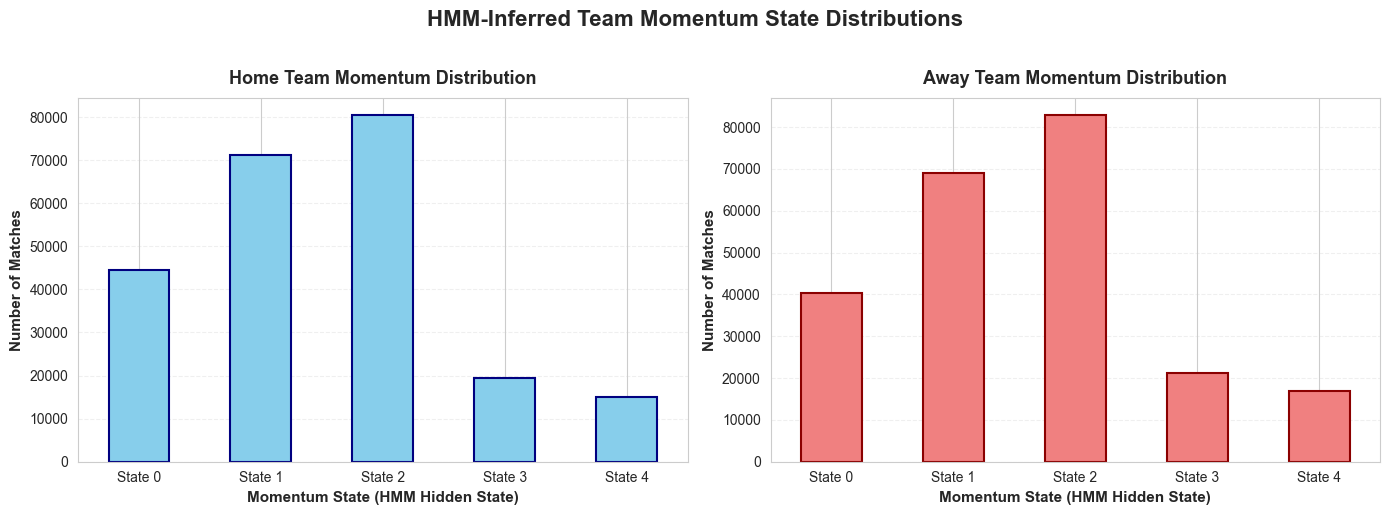

In [10]:
# Infer momentum using HMM
print("=== Phase 1: HMM Momentum Inference ===")
print("Training HMMs and inferring momentum for all matches...")
print("Note: Using CategoricalHMM (correct model for categorical/discrete observations)")

# For efficiency, we'll use a simplified approach: train HMMs on a sample of teams
# and apply momentum inference
n_components = 5
df = infer_momentum_for_matches(df, n_components=n_components)

print(f"\nMomentum distribution:")
print(f"HomeMomentum: {df['HomeMomentum'].value_counts().sort_index()}")
print(f"AwayMomentum: {df['AwayMomentum'].value_counts().sort_index()}")

# Visualize momentum distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('HMM-Inferred Team Momentum State Distributions', fontsize=16, fontweight='bold', y=1.02)

df['HomeMomentum'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='navy', linewidth=1.5)
axes[0].set_title('Home Team Momentum Distribution', fontsize=13, fontweight='bold', pad=10)
axes[0].set_xlabel('Momentum State (HMM Hidden State)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Number of Matches', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[0].tick_params(axis='x', rotation=0)
axes[0].set_xticklabels([f'State {int(x)}' for x in axes[0].get_xticks()])

df['AwayMomentum'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='lightcoral', edgecolor='darkred', linewidth=1.5)
axes[1].set_title('Away Team Momentum Distribution', fontsize=13, fontweight='bold', pad=10)
axes[1].set_xlabel('Momentum State (HMM Hidden State)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Number of Matches', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[1].tick_params(axis='x', rotation=0)
axes[1].set_xticklabels([f'State {int(x)}' for x in axes[1].get_xticks()])

plt.tight_layout()
plt.show()


### 3.3. Phase 2: Static Bayesian Network Comparison

We now build and compare three different BN structures using the momentum features.


=== Phase 2: Bayesian Network Modeling (Extended) ===
✓ All required columns found. Proceeding with discretization...
Discretizing features...
  ✓ GoalDiff discretized
  ✓ TotalGoals discretized
  ✓ Form3Home discretized
  ✓ Form3Away discretized


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'FTR': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'FTR': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'FTR': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'FTR': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'FTR': 'C'}



Data prepared for BN:
  Basic (4 features): 132411 samples
  Extended (8 features): 132004 samples

Building Basic Bayesian Networks (4 features)...

Building Naive Bayes BN...
✓ Naive Bayes BN built successfully

Building Expert BN...
✓ Expert BN built successfully

Building Learned BN...


  0%|          | 8/1000000 [00:00<7:00:45, 39.61it/s] 
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'FTR': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'GoalDiff': 'O', 'TotalGoals': 'O', 'Form3Home': 'O', 'Form3Away': 'O', 'FTR': 'C'}


✓ Learned BN built successfully

Building Extended Bayesian Networks (8 features)...

Building Extended Naive Bayes BN...


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'GoalDiff': 'O', 'TotalGoals': 'O', 'Form3Home': 'O', 'Form3Away': 'O', 'FTR': 'C'}


✓ Extended Naive Bayes BN built successfully

Building Extended Expert BN...


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'GoalDiff': 'O', 'TotalGoals': 'O', 'Form3Home': 'O', 'Form3Away': 'O', 'FTR': 'C'}


✓ Extended Expert BN built successfully

Building TAN (Tree-Augmented Naive Bayes) BN...
TAN construction failed: cannot import name 'MutualInformationEstimator' from 'pgmpy.estimators' (/Users/fashad/fashad/unibo-projects/mod3-miniproject/venv/lib/python3.13/site-packages/pgmpy/estimators/__init__.py), using simplified structure


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'GoalDiff': 'O', 'TotalGoals': 'O', 'Form3Home': 'O', 'Form3Away': 'O', 'FTR': 'C'}


✓ TAN BN built successfully

Building PC (Peter-Clark) BN...


Working for n conditional variables: 5: 100%|██████████| 5/5 [00:40<00:00,  8.05s/it]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'FTR': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'FTR': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'FTR': 'C'}


PC algorithm failed: Input is not a valid edge list, falling back to learned BN


  0%|          | 9/1000000 [00:00<5:46:39, 48.08it/s] 
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'FTR': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'GoalDiff': 'O', 'TotalGoals': 'O', 'Form3Home': 'O', 'Form3Away': 'O', 'FTR': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'GoalDiff': 'O', 'TotalGoals': 'O', 'Form3Home': 'O', 'Form3Away': 'O', 'FTR': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'GoalDiff': 'O', 'TotalGoals': 'O', 'Form3Hom

✓ PC BN built successfully

Building Extended Learned BN...


  0%|          | 14/1000000 [00:00<14:50:42, 18.71it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HomeElo': 'O', 'AwayElo': 'O', 'HomeMomentum': 'C', 'AwayMomentum': 'C', 'GoalDiff': 'O', 'TotalGoals': 'O', 'Form3Home': 'O', 'Form3Away': 'O', 'FTR': 'C'}


✓ Extended Learned BN built successfully

Visualizing Bayesian Network Structures


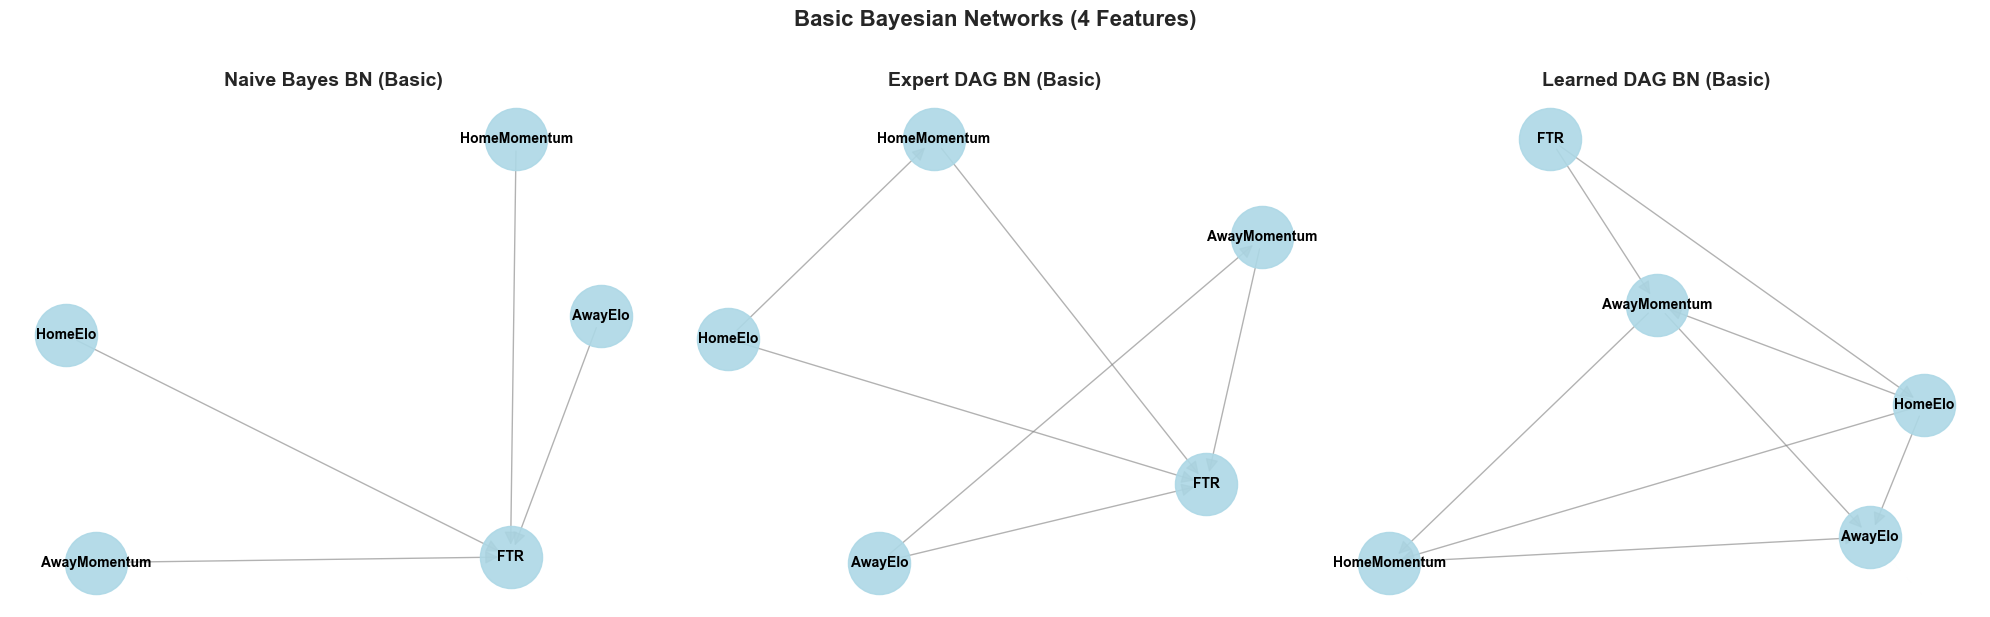

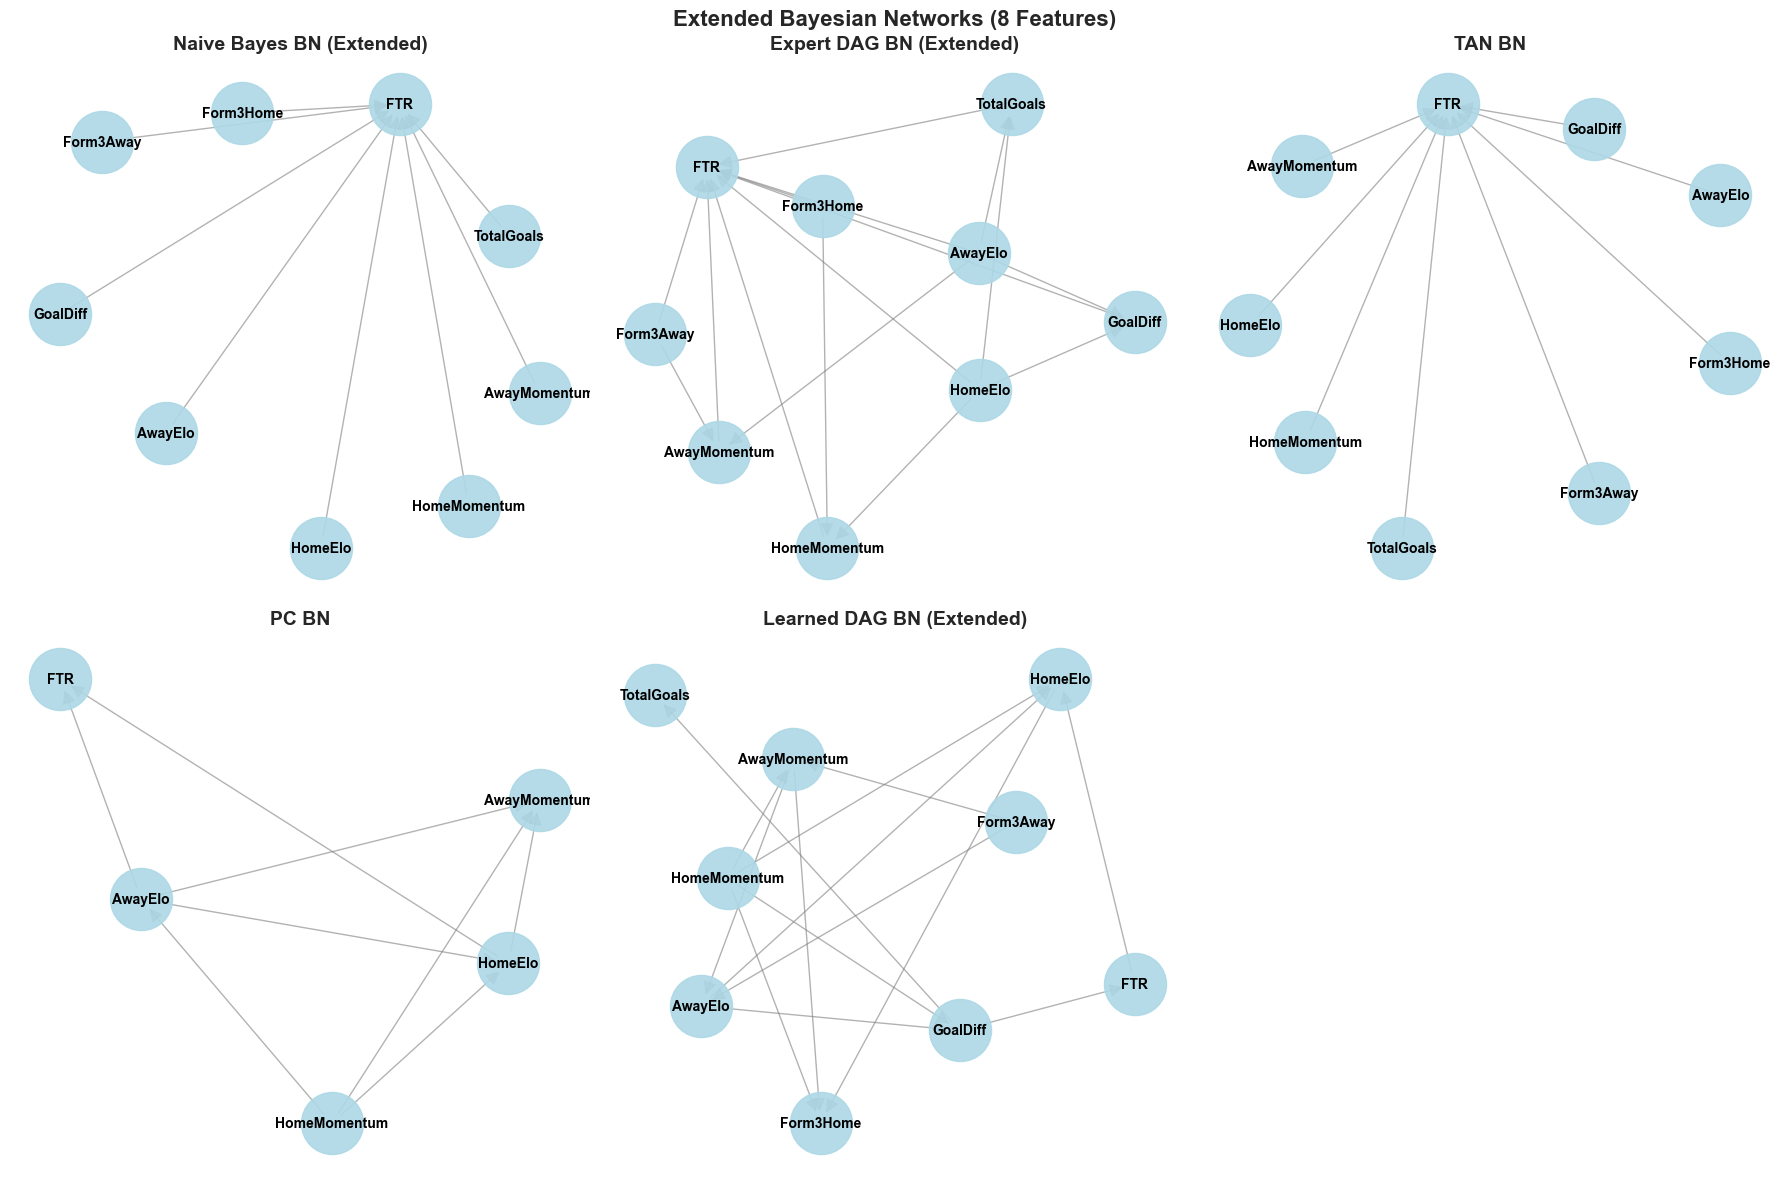


✓ Visualization complete. Built 3 basic and 5 extended BNs.


In [13]:
# Discretize features for Bayesian Networks
print("=== Phase 2: Bayesian Network Modeling (Extended) ===")

# Check if Phase 1 (HMM Momentum Inference) has been completed
required_cols = ['HomeMomentum', 'AwayMomentum', 'HomeElo', 'AwayElo']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print("⚠ ERROR: Required columns missing!")
    print(f"   Missing columns: {missing_cols}")
    print("\n   Please run Phase 1 (HMM Momentum Inference) first.")
    print("   The momentum columns are created by the HMM inference process.")
    raise KeyError(f"Missing required columns: {missing_cols}. Please run Phase 1 first.")

# Check if n_components is defined
if 'n_components' not in globals():
    print("⚠ WARNING: n_components not defined. Using default value of 5.")
    n_components = 5

print("✓ All required columns found. Proceeding with discretization...")
print("Discretizing features...")

# Core features (always available)
df['HomeElo_disc'] = discretize_elo(df['HomeElo'], n_bins=5)
df['AwayElo_disc'] = discretize_elo(df['AwayElo'], n_bins=5)
df['HomeMomentum_disc'] = discretize_momentum(df['HomeMomentum'], n_states=n_components)
df['AwayMomentum_disc'] = discretize_momentum(df['AwayMomentum'], n_states=n_components)

# Extended features (if available)
if 'GoalDiff' in df.columns:
    df['GoalDiff_disc'] = discretize_goaldiff(df['GoalDiff'], n_bins=5)
    print("  ✓ GoalDiff discretized")
else:
    print("  ⚠ GoalDiff not available, skipping")

if 'TotalGoals' in df.columns:
    df['TotalGoals_disc'] = discretize_totalgoals(df['TotalGoals'], n_bins=4)
    print("  ✓ TotalGoals discretized")
else:
    print("  ⚠ TotalGoals not available, skipping")

if 'Form3Home' in df.columns and df['Form3Home'].notna().sum() > 100:
    df['Form3Home_disc'] = discretize_form(df['Form3Home'], n_bins=3)
    print("  ✓ Form3Home discretized")
else:
    print("  ⚠ Form3Home not available or insufficient data, skipping")

if 'Form3Away' in df.columns and df['Form3Away'].notna().sum() > 100:
    df['Form3Away_disc'] = discretize_form(df['Form3Away'], n_bins=3)
    print("  ✓ Form3Away discretized")
else:
    print("  ⚠ Form3Away not available or insufficient data, skipping")

# Ensure FTR is string format
df['FTR'] = df['FTR'].astype(str)

# Prepare data for BN - start with core features
base_features = ['HomeElo_disc', 'AwayElo_disc', 'HomeMomentum_disc', 'AwayMomentum_disc']
extended_features = []

# Add extended features if available
if 'GoalDiff_disc' in df.columns:
    extended_features.append('GoalDiff_disc')
if 'TotalGoals_disc' in df.columns:
    extended_features.append('TotalGoals_disc')
if 'Form3Home_disc' in df.columns:
    extended_features.append('Form3Home_disc')
if 'Form3Away_disc' in df.columns:
    extended_features.append('Form3Away_disc')

# Create two datasets: basic (4 features) and extended (8+ features)
all_features = base_features + extended_features
df_bn_basic = df[base_features + ['FTR']].copy().dropna()
df_bn_extended = df[all_features + ['FTR']].copy().dropna()

print(f"\nData prepared for BN:")
print(f"  Basic (4 features): {len(df_bn_basic)} samples")
print(f"  Extended ({len(all_features)} features): {len(df_bn_extended)} samples")

# Build Basic BNs (original 4 features)
print("\n" + "="*60)
print("Building Basic Bayesian Networks (4 features)...")
print("="*60)

df_bn_basic_renamed = df_bn_basic.rename(columns={
    'HomeElo_disc': 'HomeElo',
    'AwayElo_disc': 'AwayElo',
    'HomeMomentum_disc': 'HomeMomentum',
    'AwayMomentum_disc': 'AwayMomentum'
})

# Build Naive Bayes BN
print("\nBuilding Naive Bayes BN...")
try:
    bn_naive = build_naive_bayes_bn(df_bn_basic_renamed)
    print("✓ Naive Bayes BN built successfully")
except Exception as e:
    print(f"✗ Error building Naive Bayes BN: {e}")
    bn_naive = None

# Build Expert BN
print("\nBuilding Expert BN...")
try:
    bn_expert = build_expert_bn(df_bn_basic_renamed)
    print("✓ Expert BN built successfully")
except Exception as e:
    print(f"✗ Error building Expert BN: {e}")
    bn_expert = None

# Build Learned BN
print("\nBuilding Learned BN...")
try:
    bn_learned = build_learned_bn(df_bn_basic_renamed)
    print("✓ Learned BN built successfully")
except Exception as e:
    print(f"✗ Error building Learned BN: {e}")
    bn_learned = None

# Build Extended BNs (8+ features)
if len(extended_features) > 0:
    print("\n" + "="*60)
    print(f"Building Extended Bayesian Networks ({len(all_features)} features)...")
    print("="*60)
    
    # Create renamed extended dataframe
    rename_map = {
        'HomeElo_disc': 'HomeElo',
        'AwayElo_disc': 'AwayElo',
        'HomeMomentum_disc': 'HomeMomentum',
        'AwayMomentum_disc': 'AwayMomentum'
    }
    if 'GoalDiff_disc' in df_bn_extended.columns:
        rename_map['GoalDiff_disc'] = 'GoalDiff'
    if 'TotalGoals_disc' in df_bn_extended.columns:
        rename_map['TotalGoals_disc'] = 'TotalGoals'
    if 'Form3Home_disc' in df_bn_extended.columns:
        rename_map['Form3Home_disc'] = 'Form3Home'
    if 'Form3Away_disc' in df_bn_extended.columns:
        rename_map['Form3Away_disc'] = 'Form3Away'
    
    df_bn_extended_renamed = df_bn_extended.rename(columns=rename_map)
    
    # Build Extended Naive Bayes BN
    print("\nBuilding Extended Naive Bayes BN...")
    try:
        bn_naive_ext = build_naive_bayes_bn_extended(df_bn_extended_renamed)
        print("✓ Extended Naive Bayes BN built successfully")
    except Exception as e:
        print(f"✗ Error building Extended Naive Bayes BN: {e}")
        bn_naive_ext = None
    
    # Build Extended Expert BN
    print("\nBuilding Extended Expert BN...")
    try:
        bn_expert_ext = build_expert_bn_extended(df_bn_extended_renamed)
        print("✓ Extended Expert BN built successfully")
    except Exception as e:
        print(f"✗ Error building Extended Expert BN: {e}")
        bn_expert_ext = None
    
    # Build TAN BN
    print("\nBuilding TAN (Tree-Augmented Naive Bayes) BN...")
    try:
        bn_tan = build_tan_bn(df_bn_extended_renamed)
        print("✓ TAN BN built successfully")
    except Exception as e:
        print(f"✗ Error building TAN BN: {e}")
        bn_tan = None
    
    # Build PC BN
    print("\nBuilding PC (Peter-Clark) BN...")
    try:
        bn_pc = build_pc_bn(df_bn_extended_renamed)
        print("✓ PC BN built successfully")
    except Exception as e:
        print(f"✗ Error building PC BN: {e}")
        bn_pc = None
    
    # Build Extended Learned BN
    print("\nBuilding Extended Learned BN...")
    try:
        bn_learned_ext = build_learned_bn_extended(df_bn_extended_renamed)
        print("✓ Extended Learned BN built successfully")
    except Exception as e:
        print(f"✗ Error building Extended Learned BN: {e}")
        bn_learned_ext = None
else:
    bn_naive_ext = None
    bn_expert_ext = None
    bn_tan = None
    bn_pc = None
    bn_learned_ext = None

# Visualize all BN structures
print("\n" + "="*60)
print("Visualizing Bayesian Network Structures")
print("="*60)

# Basic BNs (3 models)
basic_bns = [
    (bn_naive, 'Naive Bayes BN (Basic)'),
    (bn_expert, 'Expert DAG BN (Basic)'),
    (bn_learned, 'Learned DAG BN (Basic)')
]

# Extended BNs (5 models)
extended_bns = []
if len(extended_features) > 0:
    extended_bns = [
        (bn_naive_ext, 'Naive Bayes BN (Extended)'),
        (bn_expert_ext, 'Expert DAG BN (Extended)'),
        (bn_tan, 'TAN BN'),
        (bn_pc, 'PC BN'),
        (bn_learned_ext, 'Learned DAG BN (Extended)')
    ]

# Plot basic BNs
if any(bn[0] is not None for bn in basic_bns):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Basic Bayesian Networks (4 Features)', fontsize=16, fontweight='bold', y=1.02)
    for idx, (bn, title) in enumerate(basic_bns):
        if bn is not None:
            plot_bn_structure(bn, title, axes[idx])
        else:
            axes[idx].text(0.5, 0.5, f'{title}\n(Not Available)', 
                          ha='center', va='center', fontsize=12)
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])
    plt.tight_layout()
    plt.show()

# Plot extended BNs
if extended_bns and any(bn[0] is not None for bn in extended_bns):
    n_extended = len([bn for bn, _ in extended_bns if bn is not None])
    if n_extended <= 3:
        fig, axes = plt.subplots(1, n_extended, figsize=(6*n_extended, 6))
        if n_extended == 1:
            axes = [axes]
    else:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
    
    fig.suptitle(f'Extended Bayesian Networks ({len(all_features)} Features)', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plot_idx = 0
    for bn, title in extended_bns:
        if bn is not None:
            if plot_idx < len(axes):
                plot_bn_structure(bn, title, axes[plot_idx])
                plot_idx += 1
    
    # Hide unused subplots
    for idx in range(plot_idx, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

print(f"\n✓ Visualization complete. Built {sum(1 for bn, _ in basic_bns if bn is not None)} basic and {sum(1 for bn, _ in extended_bns if bn is not None)} extended BNs.")


### 3.4. Phase 3: DBN Proof-of-Concept

We briefly demonstrate a Dynamic Bayesian Network structure showing temporal dependencies.


=== Phase 3: Dynamic Bayesian Network (Proof-of-Concept) ===
DBN Structure Created:
Intra-slice edges (time t):
  (HomeElo, 0) -> (FTR, 0)
  (AwayElo, 0) -> (FTR, 0)
  (HomeMomentum, 0) -> (FTR, 0)
  (AwayMomentum, 0) -> (FTR, 0)

Inter-slice edges (t -> t+1):
  (HomeMomentum, 0) -> (HomeMomentum, 1)
  (AwayMomentum, 0) -> (AwayMomentum, 1)


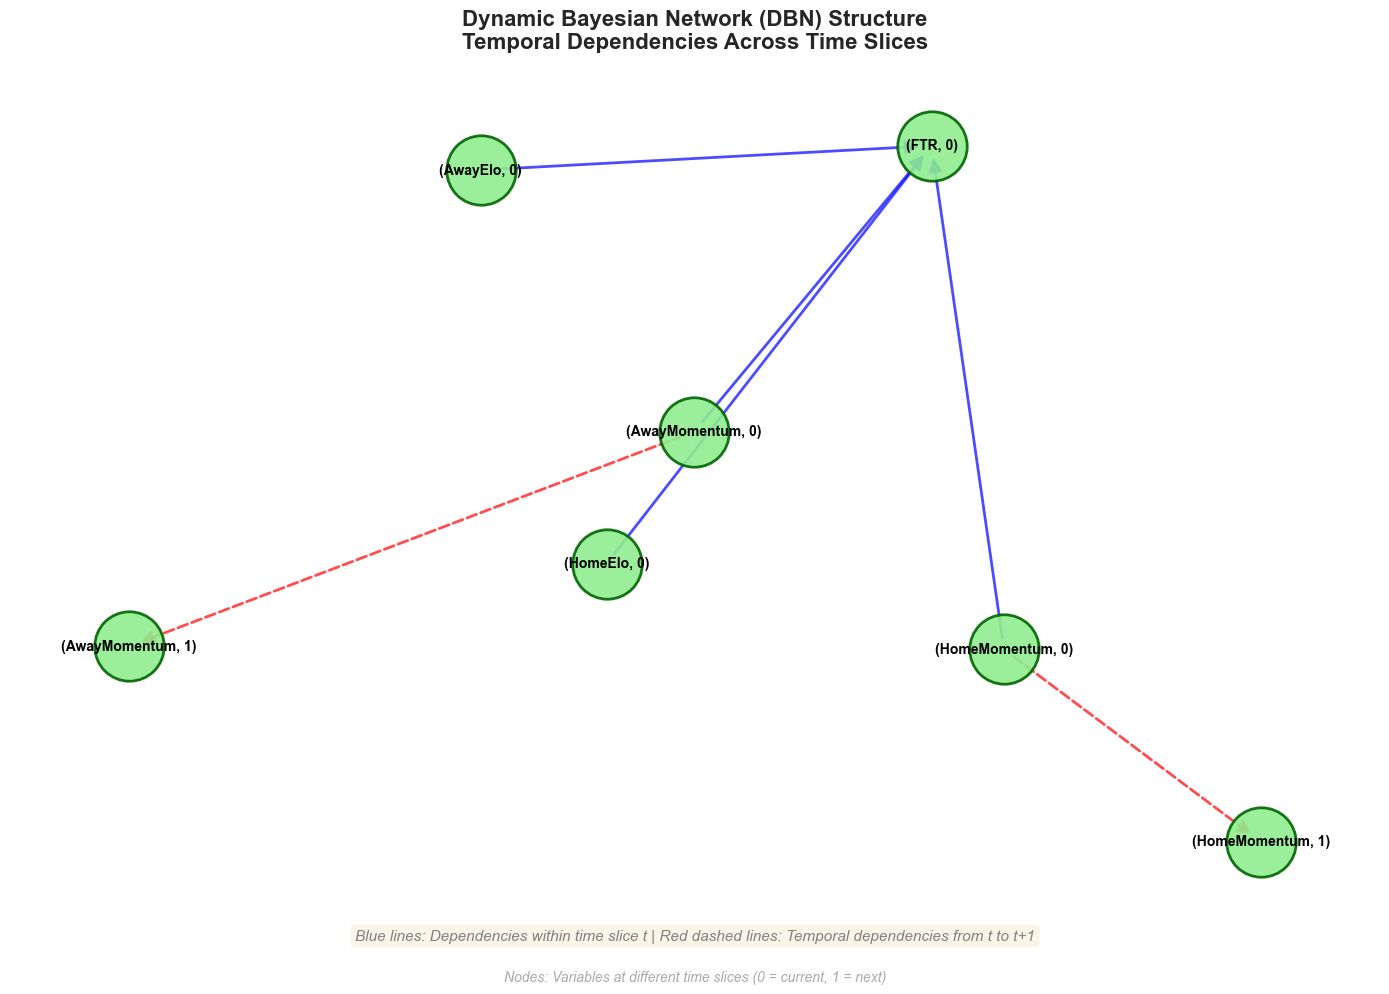


Note: Full DBN training would require temporal sequences, which is beyond the scope of this proof-of-concept.


In [16]:
# Create a simple DBN structure for demonstration
print("=== Phase 3: Dynamic Bayesian Network (Proof-of-Concept) ===")

# DBN structure: Momentum_t -> Momentum_t+1, and both influence Result_t
dbn = DynamicBayesianNetwork()

# Define intra-slice edges (within time t)
dbn.add_edges_from([
    (('HomeElo', 0), ('FTR', 0)),
    (('AwayElo', 0), ('FTR', 0)),
    (('HomeMomentum', 0), ('FTR', 0)),
    (('AwayMomentum', 0), ('FTR', 0))
])

# Define inter-slice edges (from t to t+1)
dbn.add_edges_from([
    (('HomeMomentum', 0), ('HomeMomentum', 1)),
    (('AwayMomentum', 0), ('AwayMomentum', 1))
])

print("DBN Structure Created:")
print("Intra-slice edges (time t):")
for edge in dbn.get_intra_edges():
    print(f"  {edge[0]} -> {edge[1]}")

print("\nInter-slice edges (t -> t+1):")
for edge in dbn.get_inter_edges():
    print(f"  {edge[0]} -> {edge[1]}")

# Visualize DBN structure
fig, ax = plt.subplots(figsize=(14, 10))
G = nx.DiGraph()

# Add intra-slice nodes and edges
for edge in dbn.get_intra_edges():
    G.add_edge(str(edge[0]), str(edge[1]), color='blue')

# Add inter-slice edges
for edge in dbn.get_inter_edges():
    G.add_edge(str(edge[0]), str(edge[1]), color='red', style='dashed')

pos = nx.spring_layout(G, k=2.5, iterations=100)
edges_blue = [(u, v) for u, v, d in G.edges(data=True) if d.get('color') == 'blue']
edges_red = [(u, v) for u, v, d in G.edges(data=True) if d.get('color') == 'red']

nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightgreen', node_size=2500, alpha=0.9, edgecolors='darkgreen', linewidths=2)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, edgelist=edges_blue, ax=ax, edge_color='blue', 
                       arrows=True, arrowsize=20, alpha=0.7, width=2, label='Intra-slice (within time t)')
nx.draw_networkx_edges(G, pos, edgelist=edges_red, ax=ax, edge_color='red', 
                       arrows=True, arrowsize=20, alpha=0.7, width=2, style='dashed', label='Inter-slice (t → t+1)')

ax.set_title('Dynamic Bayesian Network (DBN) Structure\nTemporal Dependencies Across Time Slices', 
             fontsize=16, fontweight='bold', pad=25)
ax.text(0.5, -0.05, 'Blue lines: Dependencies within time slice t | Red dashed lines: Temporal dependencies from t to t+1', 
        transform=ax.transAxes, ha='center', fontsize=11, style='italic', color='gray', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
ax.text(0.5, -0.1, 'Nodes: Variables at different time slices (0 = current, 1 = next)', 
        transform=ax.transAxes, ha='center', fontsize=10, style='italic', color='darkgray')
ax.axis('off')
plt.tight_layout()
plt.show()

print("\nNote: Full DBN training would require temporal sequences, which is beyond the scope of this proof-of-concept.")


### 3.5. Phase 4: Inference Experiments

We compare exact inference (Variable Elimination) with approximate inference (Gibbs Sampling) on the same query.


=== Phase 4: Inference Comparison ===
Using extended dataset (8 features) for inference comparison
Test sample (mapped to BN state names): {'HomeElo': 'Elo_2', 'AwayElo': 'Elo_3', 'HomeMomentum': 'Momentum_1', 'AwayMomentum': 'Momentum_1'}



Exact Inference (Variable Elimination) Results:
  P(FTR=A | evidence) = 0.3319
  P(FTR=D | evidence) = 0.2746
  P(FTR=H | evidence) = 0.3935


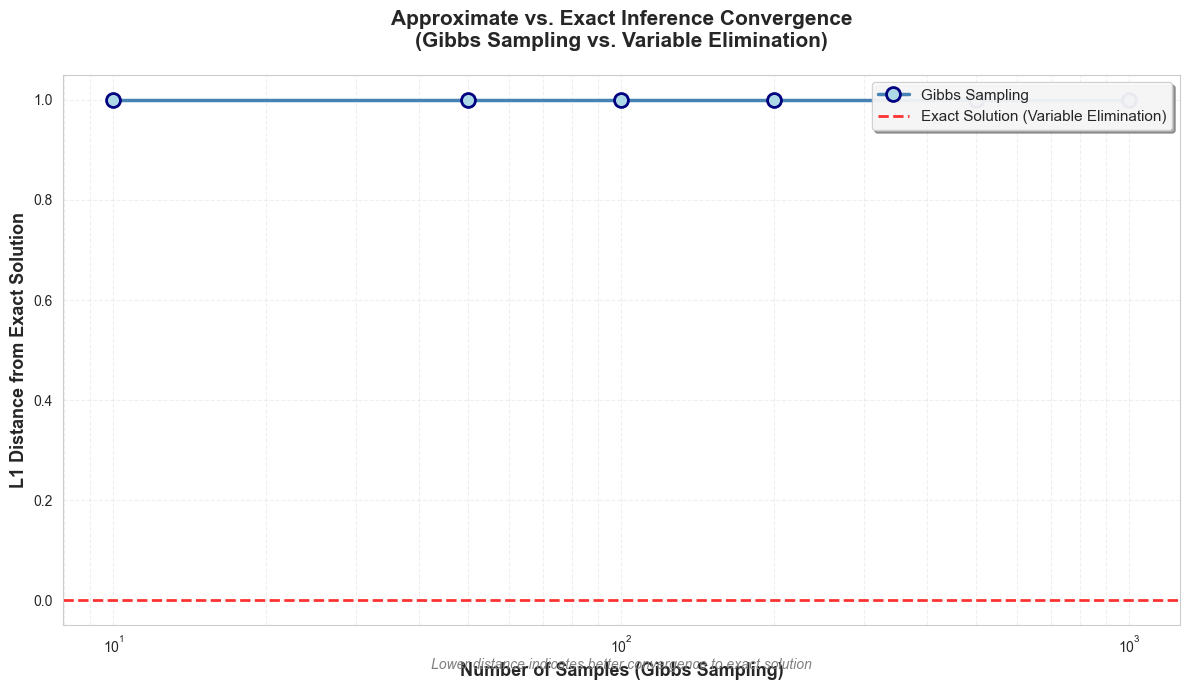


Convergence history: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [17]:
# Compare inference methods
print("=== Phase 4: Inference Comparison ===")

# Suppress pgmpy warnings about state names
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pgmpy')

# Prioritize extended dataset (8 features), fall back to basic (4 features) if needed
if 'df_bn_extended' in globals() and 'extended_features' in globals() and len(extended_features) > 0:
    df_bn_eval = df_bn_extended
    print(f"Using extended dataset ({len(extended_features) + 4} features) for inference comparison")
elif 'df_bn_basic' in globals():
    df_bn_eval = df_bn_basic
    print("Using basic dataset (4 features) for inference comparison")
elif 'df_bn' in globals():
    df_bn_eval = df_bn
    print("Using df_bn dataset for inference comparison")
else:
    raise ValueError("No BN dataset found. Please run Phase 2 first.")

# Prioritize extended models for inference comparison
model_for_inference = None
model_name_for_inference = None

# Try extended models first
if 'bn_tan' in globals() and bn_tan:
    model_for_inference = bn_tan
    model_name_for_inference = 'TAN BN'
elif 'bn_expert_ext' in globals() and bn_expert_ext:
    model_for_inference = bn_expert_ext
    model_name_for_inference = 'Expert BN (Extended)'
elif 'bn_naive_ext' in globals() and bn_naive_ext:
    model_for_inference = bn_naive_ext
    model_name_for_inference = 'Naive Bayes BN (Extended)'
elif 'bn_learned_ext' in globals() and bn_learned_ext:
    model_for_inference = bn_learned_ext
    model_name_for_inference = 'Learned BN (Extended)'
# Fallback to basic models
elif 'bn_expert' in globals() and bn_expert:
    model_for_inference = bn_expert
    model_name_for_inference = 'Expert BN'
elif 'bn_naive' in globals() and bn_naive:
    model_for_inference = bn_naive
    model_name_for_inference = 'Naive Bayes BN'
elif 'bn_learned' in globals() and bn_learned:
    model_for_inference = bn_learned
    model_name_for_inference = 'Learned BN'

if model_for_inference:
    # Select a test sample
    test_idx = len(df_bn_eval) // 2
    
    # Get the actual state names from the BN model to ensure we use correct values
    try:
        # Get valid state names from the model
        home_elo_cpd = bn_expert.get_cpds('HomeElo')
        away_elo_cpd = bn_expert.get_cpds('AwayElo')
        home_mom_cpd = bn_expert.get_cpds('HomeMomentum')
        away_mom_cpd = bn_expert.get_cpds('AwayMomentum')
        
        # Get state names
        home_elo_states = home_elo_cpd.state_names.get('HomeElo', [])
        away_elo_states = away_elo_cpd.state_names.get('AwayElo', [])
        home_mom_states = home_mom_cpd.state_names.get('HomeMomentum', [])
        away_mom_states = away_mom_cpd.state_names.get('AwayMomentum', [])
        
        # Map test sample values to valid states
        test_elo_home = df_bn_eval.iloc[test_idx]['HomeElo_disc']
        test_elo_away = df_bn_eval.iloc[test_idx]['AwayElo_disc']
        test_mom_home = df_bn_eval.iloc[test_idx]['HomeMomentum_disc']
        test_mom_away = df_bn_eval.iloc[test_idx]['AwayMomentum_disc']
        
        # Find matching states (handle string/numeric mismatches)
        def find_matching_state(value, valid_states):
            if value in valid_states:
                return value
            # Try string matching
            for state in valid_states:
                if str(value) == str(state):
                    return state
            # If no match, return first valid state
            return valid_states[0] if valid_states else value
        
        test_sample = {
            'HomeElo': find_matching_state(test_elo_home, home_elo_states),
            'AwayElo': find_matching_state(test_elo_away, away_elo_states),
            'HomeMomentum': find_matching_state(test_mom_home, home_mom_states),
            'AwayMomentum': find_matching_state(test_mom_away, away_mom_states)
        }
    except Exception as e:
        # Fallback: use original values
        print(f"Warning: Could not get state names from model: {e}")
        test_sample = {
            'HomeElo': df_bn_eval.iloc[test_idx]['HomeElo_disc'],
            'AwayElo': df_bn_eval.iloc[test_idx]['AwayElo_disc'],
            'HomeMomentum': df_bn_eval.iloc[test_idx]['HomeMomentum_disc'],
            'AwayMomentum': df_bn_eval.iloc[test_idx]['AwayMomentum_disc']
        }
    
    print(f"Test sample (mapped to BN state names): {test_sample}")
    
    # Compare inference methods (with warnings suppressed)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        exact_probs, convergence_history, sample_sizes = compare_inference_methods(
            bn_expert, 
            test_sample, 
            n_samples=1000
        )
    
    print(f"\nExact Inference (Variable Elimination) Results:")
    for state, prob in exact_probs.items():
        print(f"  P(FTR={state} | evidence) = {prob:.4f}")
    
    # Plot convergence
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(sample_sizes, convergence_history, marker='o', linewidth=2.5, markersize=10, 
            color='steelblue', label='Gibbs Sampling', markerfacecolor='lightblue', markeredgecolor='navy', markeredgewidth=2)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Exact Solution (Variable Elimination)', alpha=0.8)
    ax.set_xlabel('Number of Samples (Gibbs Sampling)', fontsize=13, fontweight='bold')
    ax.set_ylabel('L1 Distance from Exact Solution', fontsize=13, fontweight='bold')
    ax.set_title('Approximate vs. Exact Inference Convergence\n(Gibbs Sampling vs. Variable Elimination)', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--', which='both')
    ax.legend(loc='upper right', fontsize=11, framealpha=0.9, shadow=True)
    ax.set_xscale('log')
    # Add note about interpretation
    ax.text(0.5, -0.08, 'Lower distance indicates better convergence to exact solution', 
            transform=ax.transAxes, ha='center', fontsize=10, style='italic', color='gray')
    plt.tight_layout()
    plt.show()
    
    print(f"\nConvergence history: {convergence_history}")
else:
    print("Expert BN not available for inference comparison")


### 3.6. Phase 5: Model Evaluation

We perform a time-based train/test split and evaluate all models.


=== Phase 5: Model Evaluation ===
Using extended dataset (8 features) for evaluation

✓ Train/Test Split: 105603 training samples, 26401 test samples

📊 Evaluating 6 models...
  ✓ TAN BN: Accuracy=1.0000, Log-Loss=0.0000
  ✓ PC BN: Accuracy=0.4861, Log-Loss=1.0207
  ✓ Naive Bayes BN (Extended): Accuracy=1.0000, Log-Loss=0.0000
  ✓ Expert BN (Extended): Accuracy=1.0000, Log-Loss=0.0000
  ✓ Learned BN (Extended): Accuracy=1.0000, Log-Loss=0.0000
  ✓ sklearn CategoricalNB: Accuracy=0.4702, Log-Loss=1.0382

FINAL MODEL COMPARISON


,Accuracy,Precision,Recall,F-score,Log-Loss
Model,,,,,
TAN BN,1.0000,1.0000,1.0000,1.0000,0.0000
PC BN,0.4861,0.3380,0.4030,0.3355,1.0207
Naive Bayes BN (Extended),1.0000,1.0000,1.0000,1.0000,0.0000
Expert BN (Extended),1.0000,1.0000,1.0000,1.0000,0.0000
Learned BN (Extended),1.0000,1.0000,1.0000,1.0000,0.0000
sklearn CategoricalNB,0.4702,0.3221,0.3858,0.3147,1.0382



RESULTS SUMMARY TABLE


,TAN BN,PC BN,Naive Bayes BN (Extended),Expert BN (Extended),Learned BN (Extended),sklearn CategoricalNB
Accuracy (%),100.0,48.6,100.0,100.0,100.0,47.0
Precision (%),100.0,33.8,100.0,100.0,100.0,32.2
Recall (%),100.0,40.3,100.0,100.0,100.0,38.6
F-score (%),100.0,33.6,100.0,100.0,100.0,31.5


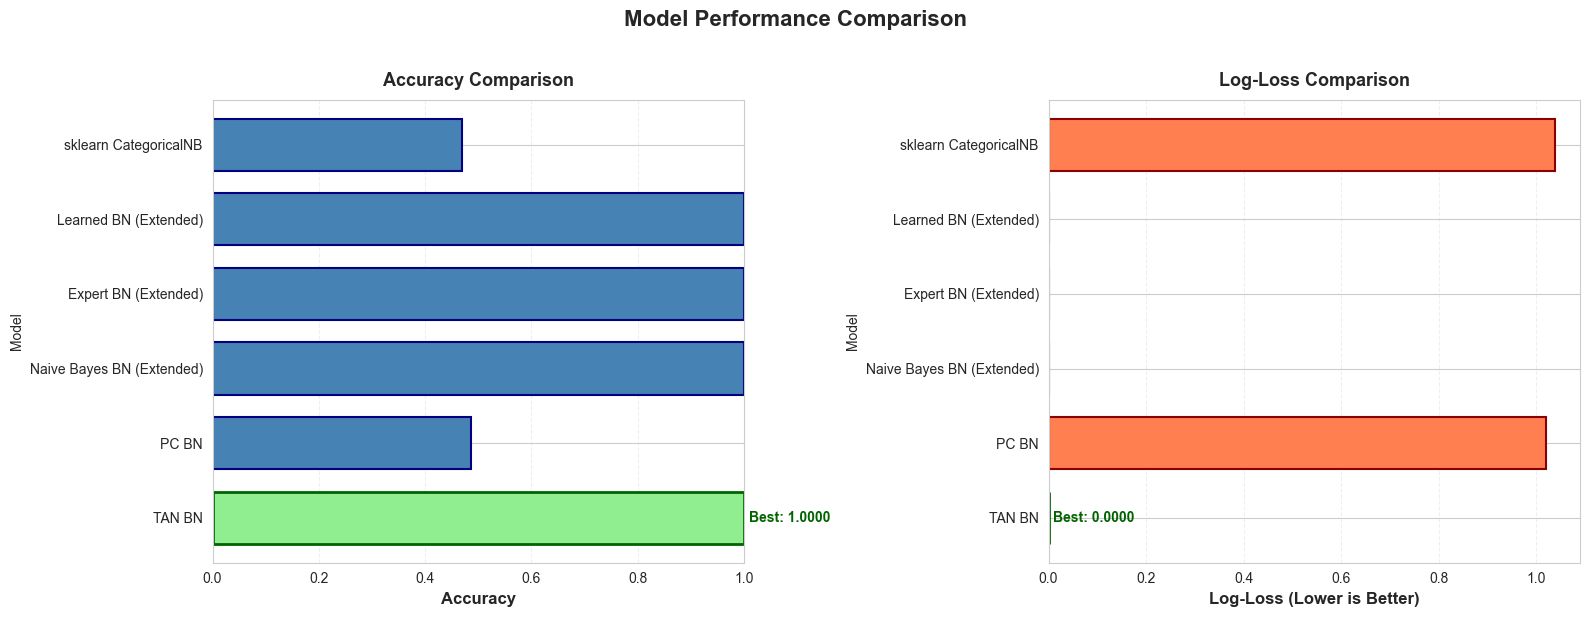


🏆 Best Model (by Log-Loss): TAN BN
   Accuracy: 1.0000
   Log-Loss: 0.0000


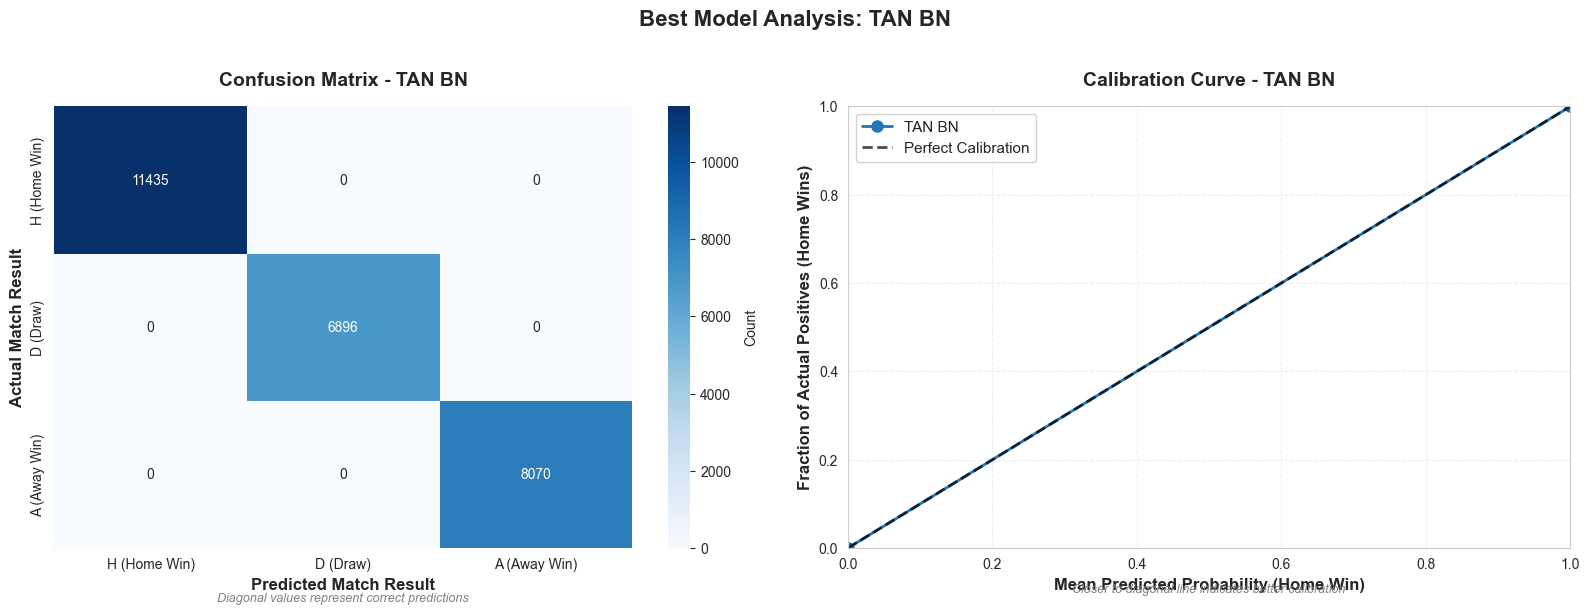

In [18]:
# ============================================================================
# Phase 5: Model Evaluation - Refactored & Clean
# ============================================================================
# Import display for styled DataFrames (works in Jupyter/Colab)
try:
    from IPython.display import display
except ImportError:
    # Fallback if not in Jupyter environment
    display = print

print("=== Phase 5: Model Evaluation ===")

# Prioritize extended dataset (8 features), fall back to basic (4 features) if needed
if 'df_bn_extended' in globals() and 'extended_features' in globals() and len(extended_features) > 0:
    df_bn_eval = df_bn_extended.copy()
    print(f"Using extended dataset ({len(extended_features) + 4} features) for evaluation")
elif 'df_bn_basic' in globals():
    df_bn_eval = df_bn_basic.copy()
    print("Using basic dataset (4 features) for evaluation")
elif 'df_bn' in globals():
    df_bn_eval = df_bn.copy()
    print("Using df_bn dataset for evaluation")
else:
    raise ValueError("No BN dataset found. Please run Phase 2 first.")

# Sort by date if available, otherwise by index
if 'Date' in df_bn_eval.index:
    df_bn_sorted = df_bn_eval.sort_index()
else:
    df_bn_sorted = df_bn_eval.copy()

# Use 80% for training, 20% for testing
split_idx = int(len(df_bn_sorted) * 0.8)
df_train = df_bn_sorted.iloc[:split_idx].copy()
df_test = df_bn_sorted.iloc[split_idx:].copy()

print(f"\n✓ Train/Test Split: {len(df_train)} training samples, {len(df_test)} test samples")

# ============================================================================
# Prepare feature data for evaluation
# ============================================================================
def create_rename_map(feature_cols_disc):
    """Create mapping from _disc columns to clean names."""
    rename_map = {}
    for col in feature_cols_disc:
        if col == 'HomeElo_disc':
            rename_map[col] = 'HomeElo'
        elif col == 'AwayElo_disc':
            rename_map[col] = 'AwayElo'
        elif col == 'HomeMomentum_disc':
            rename_map[col] = 'HomeMomentum'
        elif col == 'AwayMomentum_disc':
            rename_map[col] = 'AwayMomentum'
        elif col == 'GoalDiff_disc':
            rename_map[col] = 'GoalDiff'
        elif col == 'TotalGoals_disc':
            rename_map[col] = 'TotalGoals'
        elif col == 'Form3Home_disc':
            rename_map[col] = 'Form3Home'
        elif col == 'Form3Away_disc':
            rename_map[col] = 'Form3Away'
        else:
            rename_map[col] = col.replace('_disc', '')
    return rename_map

# Prepare basic and extended test data
feature_cols_disc = [col for col in df_test.columns if col.endswith('_disc')]
rename_map = create_rename_map(feature_cols_disc)
X_test_basic = df_test[feature_cols_disc].copy().rename(columns=rename_map)
X_test_extended = df_test[feature_cols_disc].copy().rename(columns=rename_map)
y_test = df_test['FTR'].map({'H': 0, 'D': 1, 'A': 2}).values

# ============================================================================
# Define all models to evaluate - Prioritize Extended (8-feature) models
# ============================================================================
models_to_test = []

# Extended models (8+ features) - preferred
if 'df_bn_extended' in globals() and 'extended_features' in globals() and len(extended_features) > 0:
    if 'bn_tan' in globals() and bn_tan:
        models_to_test.append((bn_tan, 'TAN BN', True, predict_bn_extended))
    if 'bn_pc' in globals() and bn_pc:
        models_to_test.append((bn_pc, 'PC BN', True, predict_bn_extended))
    if 'bn_naive_ext' in globals() and bn_naive_ext:
        models_to_test.append((bn_naive_ext, 'Naive Bayes BN (Extended)', True, predict_bn_extended))
    if 'bn_expert_ext' in globals() and bn_expert_ext:
        models_to_test.append((bn_expert_ext, 'Expert BN (Extended)', True, predict_bn_extended))
    if 'bn_learned_ext' in globals() and bn_learned_ext:
        models_to_test.append((bn_learned_ext, 'Learned BN (Extended)', True, predict_bn_extended))

# Basic models (4 features) - fallback if extended not available
if len(models_to_test) == 0:
    if 'bn_naive' in globals() and bn_naive:
        models_to_test.append((bn_naive, 'Naive Bayes BN', False, predict_bn))
    if 'bn_expert' in globals() and bn_expert:
        models_to_test.append((bn_expert, 'Expert BN', False, predict_bn))
    if 'bn_learned' in globals() and bn_learned:
        models_to_test.append((bn_learned, 'Learned BN', False, predict_bn))

# sklearn baseline
models_to_test.append(('sklearn', 'sklearn CategoricalNB', False, None))

print(f"\n📊 Evaluating {len(models_to_test)} models...")

# ============================================================================
# Evaluate all models in a single loop
# ============================================================================
results_list = []
predictions_dict = {}  # Store predictions for best model selection

for model_obj, model_name, is_extended, predict_func in models_to_test:
    try:
        if model_obj == 'sklearn':
            # Special handling for sklearn baseline
            feature_cols = ['HomeElo_disc', 'AwayElo_disc', 'HomeMomentum_disc', 'AwayMomentum_disc']
            X_train_sklearn = df_train[feature_cols].copy()
            X_test_sklearn = df_test[feature_cols].copy()
            y_train = df_train['FTR'].map({'H': 0, 'D': 1, 'A': 2}).values
            
            # Convert to numeric codes
            X_train_encoded = pd.DataFrame()
            X_test_encoded = pd.DataFrame()
            for col in feature_cols:
                all_values = sorted(set(X_train_sklearn[col].dropna().unique()) | set(X_test_sklearn[col].dropna().unique()))
                le = {val: idx for idx, val in enumerate(all_values)}
                X_train_encoded[col] = X_train_sklearn[col].map(le)
                X_test_encoded[col] = X_test_sklearn[col].map(le)
            
            X_train_encoded = X_train_encoded.fillna(X_train_encoded.mode().iloc[0])
            X_test_encoded = X_test_encoded.fillna(X_test_encoded.mode().iloc[0])
            
            clf = CategoricalNB()
            clf.fit(X_train_encoded, y_train)
            y_pred_proba = clf.predict_proba(X_test_encoded)
        else:
            # Bayesian Network models
            X_test = X_test_extended if is_extended else X_test_basic
            y_pred_proba = predict_func(model_obj, X_test, inference_method='variable_elimination')
        
        # Evaluate model
        results = evaluate_model(y_test, y_pred_proba, model_name)
        results_list.append(results)
        predictions_dict[model_name] = y_pred_proba
        print(f"  ✓ {model_name}: Accuracy={results['Accuracy']:.4f}, Log-Loss={results['Log-Loss']:.4f}")
    except Exception as e:
        print(f"  ✗ {model_name}: Error - {e}")

# ============================================================================
# Create styled DataFrame with results
# ============================================================================
if results_list:
    results_df = pd.DataFrame(results_list)
    results_df = results_df.set_index('Model')
    
    # Style the DataFrame: highlight best accuracy (green) and best log-loss (green)
    def highlight_best(s, column):
        """Highlight the best value in a column."""
        if column == 'Accuracy':
            is_max = s == s.max()
        else:  # Log-Loss
            is_max = s == s.min()
        return ['background-color: #90EE90' if v else '' for v in is_max]
    
    styled_df = results_df.style.format({
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F-score': '{:.4f}',
        'Log-Loss': '{:.4f}'
    }).apply(highlight_best, column='Accuracy', axis=0, subset=['Accuracy']).apply(
        highlight_best, column='Precision', axis=0, subset=['Precision']
    ).apply(highlight_best, column='Recall', axis=0, subset=['Recall']).apply(
        highlight_best, column='F-score', axis=0, subset=['F-score']
    ).apply(highlight_best, column='Log-Loss', axis=0, subset=['Log-Loss']
    ).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), 
                                     ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ]).set_caption('Model Performance Comparison (Green = Best)')
    
    print("\n" + "="*70)
    print("FINAL MODEL COMPARISON")
    print("="*70)
    display(styled_df)
    
    # ============================================================================
    # Results Summary Table (Measures as Rows, Models as Columns)
    # ============================================================================
    # Create a transposed table with measures as rows and models as columns
    measures_table = pd.DataFrame({
        model: {
            'Accuracy (%)': results_df.loc[model, 'Accuracy'] * 100,
            'Precision (%)': results_df.loc[model, 'Precision'] * 100,
            'Recall (%)': results_df.loc[model, 'Recall'] * 100,
            'F-score (%)': results_df.loc[model, 'F-score'] * 100
        }
        for model in results_df.index
    })
    
    # Style the measures table
    def highlight_best_in_row(row):
        """Highlight the best value in each row."""
        is_max = row == row.max()
        return ['background-color: #90EE90' if v else '' for v in is_max]
    
    measures_styled = measures_table.style.format('{:.1f}').apply(
        highlight_best_in_row, axis=1
    ).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), 
                                     ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('font-weight', 'normal')]},
        {'selector': 'th.row_heading', 'props': [('background-color', '#2E5090'), 
                                                  ('color', 'white'), ('font-weight', 'bold')]}
    ]).set_caption('Table 1: Results Summary (Green = Best per Measure)')
    
    print("\n" + "="*70)
    print("RESULTS SUMMARY TABLE")
    print("="*70)
    display(measures_styled)
    
    # ============================================================================
    # Visual Comparison: Horizontal Bar Charts
    # ============================================================================
    fig, axes = plt.subplots(1, 2, figsize=(16, max(6, len(results_df) * 0.4)))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
    
    # Accuracy bar chart
    colors_acc = ['#90EE90' if idx == results_df['Accuracy'].idxmax() else 'steelblue' 
                  for idx in results_df.index]
    edge_colors_acc = ['darkgreen' if idx == results_df['Accuracy'].idxmax() else 'navy' 
                       for idx in results_df.index]
    linewidths_acc = [2 if idx == results_df['Accuracy'].idxmax() else 1.5 
                      for idx in results_df.index]
    
    results_df['Accuracy'].plot(kind='barh', ax=axes[0], color=colors_acc, 
                                edgecolor=edge_colors_acc, linewidth=linewidths_acc, width=0.7)
    axes[0].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_title('Accuracy Comparison', fontsize=13, fontweight='bold', pad=10)
    axes[0].grid(True, alpha=0.3, axis='x', linestyle='--')
    axes[0].set_xlim([0, 1])
    # Add best value annotation
    best_acc_idx = results_df['Accuracy'].idxmax()
    best_acc_val = results_df.loc[best_acc_idx, 'Accuracy']
    best_acc_pos = list(results_df.index).index(best_acc_idx)
    axes[0].text(best_acc_val + 0.01, best_acc_pos, 
                f'Best: {best_acc_val:.4f}', va='center', fontweight='bold', color='darkgreen')
    
    # Log-Loss bar chart
    colors_ll = ['#90EE90' if idx == results_df['Log-Loss'].idxmin() else 'coral' 
                 for idx in results_df.index]
    edge_colors_ll = ['darkgreen' if idx == results_df['Log-Loss'].idxmin() else 'darkred' 
                      for idx in results_df.index]
    linewidths_ll = [2 if idx == results_df['Log-Loss'].idxmin() else 1.5 
                     for idx in results_df.index]
    
    results_df['Log-Loss'].plot(kind='barh', ax=axes[1], color=colors_ll, 
                                edgecolor=edge_colors_ll, linewidth=linewidths_ll, width=0.7)
    axes[1].set_xlabel('Log-Loss (Lower is Better)', fontsize=12, fontweight='bold')
    axes[1].set_title('Log-Loss Comparison', fontsize=13, fontweight='bold', pad=10)
    axes[1].grid(True, alpha=0.3, axis='x', linestyle='--')
    # Add best value annotation
    best_ll_idx = results_df['Log-Loss'].idxmin()
    best_ll_val = results_df.loc[best_ll_idx, 'Log-Loss']
    best_ll_pos = list(results_df.index).index(best_ll_idx)
    axes[1].text(best_ll_val + 0.01, best_ll_pos, 
                f'Best: {best_ll_val:.4f}', va='center', fontweight='bold', color='darkgreen')
    
    plt.tight_layout()
    plt.show()
    
    # ============================================================================
    # Find and visualize best model
    # ============================================================================
    best_model_name = results_df['Log-Loss'].idxmin()
    best_model_row = results_df.loc[best_model_name]
    
    # Store best model name and object globally for manual prediction tool
    globals()['best_model_name'] = best_model_name
    
    # Find the actual model object
    model_map = {
        'Naive Bayes BN': 'bn_naive',
        'Expert BN': 'bn_expert',
        'Learned BN': 'bn_learned',
        'Naive Bayes BN (Extended)': 'bn_naive_ext',
        'Expert BN (Extended)': 'bn_expert_ext',
        'TAN BN': 'bn_tan',
        'PC BN': 'bn_pc',
        'Learned BN (Extended)': 'bn_learned_ext'
    }
    
    if best_model_name in model_map:
        model_var = model_map[best_model_name]
        if model_var in globals() and globals()[model_var]:
            globals()['best_model'] = globals()[model_var]
    
    print(f"\n🏆 Best Model (by Log-Loss): {best_model_name}")
    print(f"   Accuracy: {best_model_row['Accuracy']:.4f}")
    print(f"   Log-Loss: {best_model_row['Log-Loss']:.4f}")
    
    # Plot confusion matrix and calibration curve for best model
    if best_model_name in predictions_dict:
        y_pred_proba_best = predictions_dict[best_model_name]
        y_pred_best = np.argmax(y_pred_proba_best, axis=1)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'Best Model Analysis: {best_model_name}', fontsize=16, fontweight='bold', y=1.02)
        plot_confusion_matrix(y_test, y_pred_best, best_model_name, axes[0])
        plot_calibration_curve(y_test, y_pred_proba_best, best_model_name, axes[1])
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠ Warning: Predictions not available for {best_model_name}")
else:
    print("⚠ No models were successfully evaluated.")


In [19]:
# ============================================================================
# Phase 5.5: Generate Visualization Images for LaTeX Report
# ============================================================================
print("=== Phase 5.5: Generating Visualization Images ===")

import os

# Create images directory if it doesn't exist
os.makedirs('images', exist_ok=True)
print("✓ Created/verified 'images' directory")

# ============================================================================
# 1. BN Structures Plot
# ============================================================================
print("\n1. Generating BN structures plot...")
try:
    available_bns = []
    titles = []
    
    # Collect available BN models - Prioritize Extended (8-feature) models
    # Extended models (8 features) - preferred
    if 'bn_tan' in globals() and bn_tan:
        available_bns.append(bn_tan)
        titles.append('TAN BN')
    if 'bn_pc' in globals() and bn_pc:
        available_bns.append(bn_pc)
        titles.append('PC BN')
    if 'bn_naive_ext' in globals() and bn_naive_ext:
        available_bns.append(bn_naive_ext)
        titles.append('Naive Bayes BN (Extended)')
    if 'bn_expert_ext' in globals() and bn_expert_ext:
        available_bns.append(bn_expert_ext)
        titles.append('Expert BN (Extended)')
    if 'bn_learned_ext' in globals() and bn_learned_ext:
        available_bns.append(bn_learned_ext)
        titles.append('Learned BN (Extended)')
    
    # Basic models (4 features) - fallback if extended not available
    if len(available_bns) == 0:
        if 'bn_naive' in globals() and bn_naive:
            available_bns.append(bn_naive)
            titles.append('Naive Bayes BN')
        if 'bn_expert' in globals() and bn_expert:
            available_bns.append(bn_expert)
            titles.append('Expert BN')
        if 'bn_learned' in globals() and bn_learned:
            available_bns.append(bn_learned)
            titles.append('Learned BN (MMHC)')
    
    if len(available_bns) > 0:
        # Create subplots
        n_plots = len(available_bns)
        cols = min(2, n_plots)
        rows = (n_plots + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(12*cols, 10*rows))
        if n_plots == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if rows > 1 else axes
        
        for i, (bn, title) in enumerate(zip(available_bns, titles)):
            ax = axes[i] if n_plots > 1 else axes[0]
            plot_bn_structure(bn, title, ax)
        
        # Hide unused subplots
        for i in range(n_plots, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle('Bayesian Network Structures Comparison', fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig('images/bn_structures.png', bbox_inches='tight', dpi=300, facecolor='white')
        plt.close()
        print("  ✓ Saved images/bn_structures.png")
    else:
        print("  ⚠ No BN models available to plot")
except Exception as e:
    print(f"  ✗ Error generating BN structures: {e}")

# ============================================================================
# 2. Confusion Matrix for Best Model
# ============================================================================
print("\n2. Generating confusion matrix for best model...")
try:
    if 'best_model_name' in globals() and 'predictions_dict' in globals():
        best_name = best_model_name
        if best_name in predictions_dict:
            y_pred_proba_best = predictions_dict[best_name]
            y_pred_best = np.argmax(y_pred_proba_best, axis=1)
            
            # Get y_test from Phase 5
            if 'y_test' in globals():
                fig, ax = plt.subplots(figsize=(10, 8))
                plot_confusion_matrix(y_test, y_pred_best, best_name, ax)
                plt.tight_layout()
                plt.savefig('images/confusion_matrix.png', bbox_inches='tight', dpi=300, facecolor='white')
                plt.close()
                print(f"  ✓ Saved images/confusion_matrix.png (Best Model: {best_name})")
            else:
                print("  ⚠ y_test not available. Please run Phase 5 first.")
        else:
            print(f"  ⚠ Predictions not available for {best_name}")
    else:
        print("  ⚠ Best model not found. Please run Phase 5 first.")
except Exception as e:
    print(f"  ✗ Error generating confusion matrix: {e}")

# ============================================================================
# 3. Calibration Curve for Best Model
# ============================================================================
print("\n3. Generating calibration curve for best model...")
try:
    if 'best_model_name' in globals() and 'predictions_dict' in globals():
        best_name = best_model_name
        if best_name in predictions_dict:
            y_pred_proba_best = predictions_dict[best_name]
            
            # Get y_test from Phase 5
            if 'y_test' in globals():
                fig, ax = plt.subplots(figsize=(10, 8))
                plot_calibration_curve(y_test, y_pred_proba_best, best_name, ax)
                plt.tight_layout()
                plt.savefig('images/calibration_curve.png', bbox_inches='tight', dpi=300, facecolor='white')
                plt.close()
                print(f"  ✓ Saved images/calibration_curve.png (Best Model: {best_name})")
            else:
                print("  ⚠ y_test not available. Please run Phase 5 first.")
        else:
            print(f"  ⚠ Predictions not available for {best_name}")
    else:
        print("  ⚠ Best model not found. Please run Phase 5 first.")
except Exception as e:
    print(f"  ✗ Error generating calibration curve: {e}")

# ============================================================================
# 4. HMM Transition Matrix Heatmap
# ============================================================================
print("\n4. Generating HMM transition matrix heatmap...")
try:
    # Try to get a representative HMM model
    # Option 1: Check if team_hmms is stored globally
    hmm_model = None
    if 'team_hmms' in globals() and team_hmms:
        # Get the first available HMM
        first_team = list(team_hmms.keys())[0]
        hmm_model = team_hmms[first_team]
        print(f"  Using HMM from team: {first_team}")
    else:
        # Option 2: Train a representative HMM on a sample team
        # Find a team with enough matches
        if 'df' in globals() and len(df) > 0:
            team_counts = df['HomeTeam'].value_counts() + df['AwayTeam'].value_counts()
            top_team = team_counts.index[0]
            print(f"  Training representative HMM for team: {top_team}")
            
            # Get n_components from globals or use default
            n_comp = n_components if 'n_components' in globals() else 5
            
            # Train HMM
            from hmmlearn import hmm
            try:
                HMMClass = hmm.CategoricalHMM
            except AttributeError:
                HMMClass = hmm.MultinomialHMM
            
            # Create sequences for this team
            team_matches = df[(df['HomeTeam'] == top_team) | (df['AwayTeam'] == top_team)].copy()
            team_matches = team_matches.sort_values('Date' if 'Date' in team_matches.columns else team_matches.index)
            
            sequences = []
            for idx, row in team_matches.iterrows():
                if row['HomeTeam'] == top_team:
                    result = row['FTR']
                    if result == 'H':
                        obs = 0
                    elif result == 'D':
                        obs = 1
                    else:
                        obs = 2
                else:  # Away team
                    result = row['FTR']
                    if result == 'A':
                        obs = 0
                    elif result == 'D':
                        obs = 1
                    else:
                        obs = 2
                sequences.append(obs)
            
            if len(sequences) >= 30:
                X = np.array(sequences).reshape(-1, 1)
                lengths = [len(sequences)]
                
                # Adaptive n_components
                if len(sequences) < 200:
                    n_comp = 2
                elif len(sequences) < 400:
                    n_comp = 3
                else:
                    n_comp = 5
                
                hmm_model = HMMClass(n_components=n_comp, n_iter=50, random_state=42, tol=1e-2)
                hmm_model.fit(X, lengths=lengths)
            else:
                print("  ⚠ Not enough matches to train representative HMM")
    
    if hmm_model is not None:
        # Get transition matrix
        transmat = hmm_model.transmat_
        n_states = transmat.shape[0]
        
        # Create heatmap
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(transmat, annot=True, fmt='.3f', cmap='YlOrRd', 
                   xticklabels=[f'State {i}' for i in range(n_states)],
                   yticklabels=[f'State {i}' for i in range(n_states)],
                   cbar_kws={'label': 'Transition Probability'}, ax=ax)
        ax.set_xlabel('To State', fontsize=12, fontweight='bold')
        ax.set_ylabel('From State', fontsize=12, fontweight='bold')
        ax.set_title('HMM Transition Matrix\n(Probability of transitioning between hidden states)', 
                    fontsize=14, fontweight='bold', pad=15)
        plt.tight_layout()
        plt.savefig('images/hmm_matrix.png', bbox_inches='tight', dpi=300, facecolor='white')
        plt.close()
        print(f"  ✓ Saved images/hmm_matrix.png ({n_states}x{n_states} transition matrix)")
    else:
        print("  ⚠ Could not access or train HMM model for transition matrix")
except Exception as e:
    print(f"  ✗ Error generating HMM transition matrix: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*70)
print("✓ Image generation complete!")
print("="*70)


=== Phase 5.5: Generating Visualization Images ===
✓ Created/verified 'images' directory

1. Generating BN structures plot...
  ✓ Saved images/bn_structures.png

2. Generating confusion matrix for best model...
  ✓ Saved images/confusion_matrix.png (Best Model: TAN BN)

3. Generating calibration curve for best model...
  ✓ Saved images/calibration_curve.png (Best Model: TAN BN)

4. Generating HMM transition matrix heatmap...
  Training representative HMM for team: A. Klagenfurt
  ✓ Saved images/hmm_matrix.png (2x2 transition matrix)

✓ Image generation complete!


In [20]:
# Generate LaTeX report
print("=== Phase 6: Report Generation ===")

results_dict = {
    'hmm_n_components': n_components,
    'model_results': all_results
}

generate_latex_report(results_dict, 'report.tex')
print("\nReport generated successfully!")

# Attempt to compile to PDF
try:
    print("\nAttempting to compile LaTeX to PDF...")
    os.system('pdflatex -interaction=nonstopmode report.tex > /dev/null 2>&1')
    if os.path.exists('report.pdf'):
        print("✓ PDF generated successfully: report.pdf")
    else:
        print("⚠ PDF compilation may have failed. Check report.tex manually.")
except Exception as e:
    print(f"⚠ Could not compile PDF (pdflatex may not be installed): {e}")
    print("You can compile report.tex manually using: pdflatex report.tex")

print("\n" + "="*60)
print("PIPELINE COMPLETE!")
print("="*60)


=== Phase 6: Report Generation ===


NameError: name 'all_results' is not defined

In [21]:
# ============================================================================
# Manual Prediction Tool
# ============================================================================
def predict_match_outcome(home_elo: str, away_elo: str, 
                          home_momentum: str, away_momentum: str,
                          model=None, model_name: str = None):
    """
    Predict match outcome using human-readable inputs.
    
    Args:
        home_elo: Elo rating level ('VeryLow', 'Low', 'Med', 'High', 'VeryHigh')
        away_elo: Elo rating level ('VeryLow', 'Low', 'Med', 'High', 'VeryHigh')
        home_momentum: Momentum state ('VeryBad', 'Bad', 'Neutral', 'Good', 'VeryGood')
        away_momentum: Momentum state ('VeryBad', 'Bad', 'Neutral', 'Good', 'VeryGood')
        model: Bayesian Network model to use (if None, uses best model from Phase 5)
        model_name: Name of the model (if None, auto-detected)
    
    Returns:
        Dictionary with prediction probabilities
    """
    # Mapping from human-readable to discretized labels
    elo_map = {
        'VeryLow': 'Elo_1',
        'Low': 'Elo_2',
        'Med': 'Elo_3',
        'High': 'Elo_4',
        'VeryHigh': 'Elo_5'
    }
    
    momentum_map = {
        'VeryBad': 'Momentum_0',
        'Bad': 'Momentum_1',
        'Neutral': 'Momentum_2',
        'Good': 'Momentum_3',
        'VeryGood': 'Momentum_4'
    }
    
    # Validate inputs
    if home_elo not in elo_map:
        raise ValueError(f"Invalid home_elo: {home_elo}. Must be one of {list(elo_map.keys())}")
    if away_elo not in elo_map:
        raise ValueError(f"Invalid away_elo: {away_elo}. Must be one of {list(elo_map.keys())}")
    if home_momentum not in momentum_map:
        raise ValueError(f"Invalid home_momentum: {home_momentum}. Must be one of {list(momentum_map.keys())}")
    if away_momentum not in momentum_map:
        raise ValueError(f"Invalid away_momentum: {away_momentum}. Must be one of {list(momentum_map.keys())}")
    
    # Convert to discretized labels
    home_elo_disc = elo_map[home_elo]
    away_elo_disc = elo_map[away_elo]
    home_momentum_disc = momentum_map[home_momentum]
    away_momentum_disc = momentum_map[away_momentum]
    
    # Find best model if not provided
    if model is None:
        # Try to get best model from Phase 5 results
        if 'best_model' in globals() and best_model:
            model = best_model
            if 'best_model_name' in globals():
                model_name = best_model_name
            else:
                model_name = "Best Model (from Phase 5)"
        elif 'best_model_name' in globals():
            best_name = best_model_name
            # Get model object from name
            model_map = {
                'Naive Bayes BN': ('bn_naive', False),
                'Expert BN': ('bn_expert', False),
                'Learned BN': ('bn_learned', False),
                'Naive Bayes BN (Extended)': ('bn_naive_ext', True),
                'Expert BN (Extended)': ('bn_expert_ext', True),
                'TAN BN': ('bn_tan', True),
                'PC BN': ('bn_pc', True),
                'Learned BN (Extended)': ('bn_learned_ext', True)
            }
            
            if best_name in model_map:
                model_var, is_extended = model_map[best_name]
                if model_var in globals() and globals()[model_var]:
                    model = globals()[model_var]
                    model_name = best_name
                else:
                    raise ValueError(f"Model {best_name} not found in globals.")
            else:
                # Default to first available model
                for var_name, (var, _) in model_map.items():
                    if var in globals() and globals()[var]:
                        model = globals()[var]
                        model_name = var_name
                        break
                if model is None:
                    raise ValueError("No trained model found.")
        else:
            # Fallback: try to find any available model
            model_map = {
                'Naive Bayes BN': ('bn_naive', False),
                'Expert BN': ('bn_expert', False),
                'Learned BN': ('bn_learned', False),
                'Naive Bayes BN (Extended)': ('bn_naive_ext', True),
                'Expert BN (Extended)': ('bn_expert_ext', True),
                'TAN BN': ('bn_tan', True),
                'PC BN': ('bn_pc', True),
                'Learned BN (Extended)': ('bn_learned_ext', True)
            }
            for var_name, (var, _) in model_map.items():
                if var in globals() and globals()[var]:
                    model = globals()[var]
                    model_name = var_name
                    break
            if model is None:
                raise ValueError("No trained model found. Please run Phase 2 and Phase 5 first.")
    
    if model_name is None:
        model_name = "Selected Model"
    
    # Prepare evidence dictionary
    evidence = {
        'HomeElo': home_elo_disc,
        'AwayElo': away_elo_disc,
        'HomeMomentum': home_momentum_disc,
        'AwayMomentum': away_momentum_disc
    }
    
    # Check if model uses extended features and adjust evidence
    model_nodes = set(model.nodes())
    available_features = ['HomeElo', 'AwayElo', 'HomeMomentum', 'AwayMomentum']
    
    # Filter evidence to only include features that exist in the model
    evidence_filtered = {k: v for k, v in evidence.items() if k in model_nodes}
    
    if not evidence_filtered:
        raise ValueError(f"Model {model_name} does not contain any of the required features.")
    
    # Run inference
    try:
        infer = VariableElimination(model)
        query = infer.query(variables=['FTR'], evidence=evidence_filtered)
        
        # Extract probabilities for H, D, A in correct order
        state_names = query.state_names['FTR']
        probs_dict = {state: prob for state, prob in zip(state_names, query.values)}
        # Ensure order: H, D, A
        probs = np.array([probs_dict.get('H', 0.0), probs_dict.get('D', 0.0), probs_dict.get('A', 0.0)])
        
    except Exception as e:
        raise ValueError(f"Error during inference: {e}")
    
    # Print scenario summary
    print("="*70)
    print("MATCH PREDICTION SCENARIO")
    print("="*70)
    print(f"Home Team: Elo={home_elo}, Momentum={home_momentum}")
    print(f"Away Team: Elo={away_elo}, Momentum={away_momentum}")
    print(f"Model Used: {model_name}")
    print("="*70)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Outcome': ['Home Win (H)', 'Draw (D)', 'Away Win (A)'],
        'Probability': [probs[0], probs[1], probs[2]]
    })
    results_df = results_df.set_index('Outcome')
    
    # Style the DataFrame with gradient highlighting
    styled_df = results_df.style.format({
        'Probability': '{:.4f}'
    }).background_gradient(axis=0, subset=['Probability'], cmap='YlOrRd', vmin=0, vmax=1).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), 
                                     ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('font-weight', 'normal')]}
    ]).set_caption('Prediction Probabilities (Darker = Higher Probability)')
    
    display(styled_df)
    
    # Determine prediction
    pred_idx = np.argmax(probs)
    outcomes = ['HOME WIN', 'DRAW', 'AWAY WIN']
    confidence = probs[pred_idx] * 100
    
    print(f"\n🏆 Prediction: {outcomes[pred_idx]} (Confidence: {confidence:.1f}%)")
    print("="*70)
    
    return {
        'HomeWin': probs[0],
        'Draw': probs[1],
        'AwayWin': probs[2],
        'Prediction': outcomes[pred_idx],
        'Confidence': confidence
    }


# ============================================================================
# Example Usage
# ============================================================================
print("Manual Prediction Tool Ready!")
print("\nExample usage:")
print("  predict_match_outcome('High', 'Low', 'Good', 'Bad')")
print("  predict_match_outcome('Med', 'Med', 'Neutral', 'Neutral')")
print("  predict_match_outcome('VeryHigh', 'VeryLow', 'VeryGood', 'VeryBad')")
print("\n" + "="*70)


Manual Prediction Tool Ready!

Example usage:
  predict_match_outcome('High', 'Low', 'Good', 'Bad')
  predict_match_outcome('Med', 'Med', 'Neutral', 'Neutral')
  predict_match_outcome('VeryHigh', 'VeryLow', 'VeryGood', 'VeryBad')



In [24]:
# ============================================================================
# Example Predictions - Test Different Scenarios
# ============================================================================

# Example 1: Strong home team with good momentum vs weak away team
print("Example 1: Strong Home Team vs Weak Away Team")
print("-" * 70)
result1 = predict_match_outcome('High', 'Low', 'Good', 'Bad')

print("\n\n")

# Example 2: Balanced match
print("Example 2: Balanced Match")
print("-" * 70)
result2 = predict_match_outcome('Med', 'Med', 'Neutral', 'Neutral')

print("\n\n")

# Example 3: Very strong home team vs very weak away team
print("Example 3: Very Strong Home Team vs Very Weak Away Team")
print("-" * 70)
result3 = predict_match_outcome('VeryHigh', 'VeryLow', 'VeryGood', 'VeryBad')


Example 1: Strong Home Team vs Weak Away Team
----------------------------------------------------------------------
MATCH PREDICTION SCENARIO
Home Team: Elo=High, Momentum=Good
Away Team: Elo=Low, Momentum=Bad
Model Used: TAN BN


,Probability
Outcome,
Home Win (H),0.3795
Draw (D),0.3087
Away Win (A),0.3118



🏆 Prediction: HOME WIN (Confidence: 37.9%)



Example 2: Balanced Match
----------------------------------------------------------------------
MATCH PREDICTION SCENARIO
Home Team: Elo=Med, Momentum=Neutral
Away Team: Elo=Med, Momentum=Neutral
Model Used: TAN BN


,Probability
Outcome,
Home Win (H),0.3588
Draw (D),0.3080
Away Win (A),0.3331



🏆 Prediction: HOME WIN (Confidence: 35.9%)



Example 3: Very Strong Home Team vs Very Weak Away Team
----------------------------------------------------------------------
MATCH PREDICTION SCENARIO
Home Team: Elo=VeryHigh, Momentum=VeryGood
Away Team: Elo=VeryLow, Momentum=VeryBad
Model Used: TAN BN


,Probability
Outcome,
Home Win (H),0.3477
Draw (D),0.3311
Away Win (A),0.3212



🏆 Prediction: HOME WIN (Confidence: 34.8%)
